In [1]:
import warnings
warnings.filterwarnings('ignore')
import wradlib as wrl
import matplotlib.pyplot as pl
import matplotlib as mpl
from matplotlib.collections import PatchCollection
from matplotlib.colors import from_levels_and_colors
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib.cm as cm
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np
import datetime as dt
from osgeo import osr
warnings.filterwarnings('ignore')
from satlib import corcor
import os
import time
from mpl_toolkits.mplot3d import Axes3D




/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationW

In [2]:
def subplot_cfad(x1, x2, ZP):
    """
    Plot 4 CFAD
    """
    import matplotlib.pyplot as plt
    m1 = ~np.isnan(x1) & ~np.isnan(x2)
    
    x3 = np.array([]); x4 = np.array([]); x5 = np.array([np.nan])

    hh = np.array([])
    for jj in range(0,20000,100):
        hh = np.append(hh,jj)
        x3 = np.append(x3,np.nanmean(x1[np.where((x2>jj)&(x2<jj+100))]))
        x4 = np.append(x4,np.nanmedian(x1[np.where((x2>jj)&(x2<jj+100))]))
        x0 = x1.copy()
        if x0[np.where((x2>jj)&(x2<jj+100))].size==0:
            x5 = np.append(x5,0)
        else:
            x5 = np.append(x5,np.nanmax(x0[np.where((x2>jj)&(x2<jj+100))]))
    
    print hh.shape, x5.shape, x4.shape
    plt.hist2d(x1[m1], x2[m1],bins=30, cmap='inferno', vmax=40)
    #plt.hexbin(x1[m1], x2[m1],bins=10, cmap='inferno')
    plt.colorbar()
    plt.xlabel('ZH in DBz')
    plt.ylabel('Height in m')
    plt.title('CFAD: '+ ZP)
    plt.plot(x3,hh, linewidth=2, label='mean')
    plt.plot(x4,hh, linewidth=2, label='median')
    #plt.plot(x5[1::],hh, linewidth=2, label='max', color='white')
    # BB detection with cfad?
    #plt.axhline(0, color='white')

    plt.legend(loc='upper right', fontsize=10)
    plt.grid(color='white')
    #plt.close()
    plt.ylim(250,7200)
    #plt.show()



In [3]:
from netCDF4 import Dataset
#from wradlib import get_clip_mask

def read_gpm(filename, bbox):
    scan='NS' # NS, MS, HS
    pr_data = Dataset(filename, mode="r")
    lon = pr_data[scan].variables['Longitude']
    lat = pr_data[scan].variables['Latitude']

    poly = [[bbox['left'], bbox['bottom']],
            [bbox['left'], bbox['top']],
            [bbox['right'], bbox['top']],
            [bbox['right'], bbox['bottom']],
            [bbox['left'], bbox['bottom']]]
    mask = wrl.zonalstats.get_clip_mask(np.dstack((lon[:], lat[:])), poly)
    mask = np.nonzero(np.count_nonzero(mask, axis=1))
    lon = lon[mask]
    lat = lat[mask]

    year = pr_data[scan]['ScanTime'].variables['Year'][mask]
    month = pr_data[scan]['ScanTime'].variables['Month'][mask]
    dayofmonth = pr_data[scan]['ScanTime'].variables['DayOfMonth'][mask]
    # dayofyear = pr_data[scan]['ScanTime'].variables['DayOfYear'][mask]
    hour = pr_data[scan]['ScanTime'].variables['Hour'][mask]
    minute = pr_data[scan]['ScanTime'].variables['Minute'][mask]
    second = pr_data[scan]['ScanTime'].variables['Second'][mask]
    # secondofday = pr_data[scan]['ScanTime'].variables['SecondOfDay'][mask]
    millisecond = pr_data[scan]['ScanTime'].variables['MilliSecond'][mask]
    date_array = zip(year, month, dayofmonth,
                     hour, minute, second,
                     millisecond.astype(np.int32) * 1000)
    pr_time = np.array(
        [dt.datetime(d[0], d[1], d[2], d[3], d[4], d[5], d[6]) for d in
         date_array])
    
    #DPR Altitude in m 
    dpr_alt = pr_data[scan]['navigation'].variables['dprAlt'][mask]
    print ('dpr_alt: ', dpr_alt)

    sfc = pr_data[scan]['PRE'].variables['landSurfaceType'][mask]
    pflag = pr_data[scan]['PRE'].variables['flagPrecip'][mask]

    # bbflag = pr_data[scan]['CSF'].variables['flagBB'][mask]
    zbb = pr_data[scan]['CSF'].variables['heightBB'][mask]
    # print(zbb.dtype)
    bbwidth = pr_data[scan]['CSF'].variables['widthBB'][mask]
    qbb = pr_data[scan]['CSF'].variables['qualityBB'][mask]
    qtype = pr_data[scan]['CSF'].variables['qualityTypePrecip'][mask]
    ptype = pr_data[scan]['CSF'].variables['typePrecip'][mask]

    quality = pr_data[scan]['scanStatus'].variables['dataQuality'][mask]
    
    #### REFL
    refl = pr_data[scan]['SLV'].variables['zFactorCorrected'][mask]
    #refl = pr_data[scan]['PRE'].variables['zFactorMeasured'][mask]
    # print(pr_data[scan]['SLV'].variables['zFactorCorrected']) 
    
    #### DFR
    #refl_ns = pr_data['NS']['PRE'].variables['zFactorMeasured'][mask]
    ## Auf Ka zuschneiden
    #refl_ns = refl_ns[:,12:37]
    
    #refl_ms = pr_data['MS']['PRE'].variables['zFactorMeasured'][mask]
    #refl = refl_ns - refl_ms
    

    zenith = pr_data[scan]['PRE'].variables['localZenithAngle'][mask]

    pr_data.close()

    # Check for bad data
    if max(quality) != 0:
        raise ValueError('GPM contains Bad Data')

    pflag = pflag.astype(np.int8)

    # Determine the dimensions
    ndim = refl.ndim
    if ndim != 3:
        raise ValueError('GPM Dimensions do not match! '
                         'Needed 3, given {0}'.format(ndim))

    tmp = refl.shape
    nscan = tmp[0]
    nray = tmp[1]
    nbin = tmp[2]

    # Reverse direction along the beam
    refl = np.flip(refl, axis=-1)

    # Change pflag=1 to pflag=2 to be consistent with 'Rain certain' in TRMM
    pflag[pflag == 1] = 2

    # Simplify the precipitation types
    ptype = (ptype / 1e7).astype(np.int16)

    # Simplify the surface types
    imiss = (sfc == -9999)
    sfc = (sfc / 1e2).astype(np.int16) + 1
    sfc[imiss] = 0

    # Set a quality indicator for the BB and precip type data
    # TODO: Why is the `quality` variable overwritten?

    quality = np.zeros((nscan, nray), dtype=np.uint8)

    i1 = ((qbb == 0) | (qbb == 1)) & (qtype == 1)
    quality[i1] = 1

    i2 = ((qbb > 1) | (qtype > 2))
    quality[i2] = 2

    gpm_data = {}
    gpm_data.update({'nscan': nscan, 'nray': nray, 'nbin': nbin,
                     'date': pr_time, 'lon': lon, 'lat': lat,
                     'pflag': pflag, 'ptype': ptype, 'zbb': zbb,
                     'bbwidth': bbwidth, 'sfc': sfc, 'quality': quality,
                     'refl': refl, 'zenith': zenith, 'dpr_alt':dpr_alt})

    return gpm_data

In [4]:
# define GPM data set
# ----------------------
#-#gpm_file_path = '/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20141007-S015721-E032951.003445.V05A.HDF5'


gpm_file_path = '/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20141008-S084747-E102017.003465.V05A.HDF5'
#gpm_file_path = '/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20160601-S171836-E185110.012837.V05A.HDF5'
#gpm_file_path = '/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20150330-S224903-E002135.006166.V05A.HDF5'
#gpm_file_path = '/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20151216-S014742-E032015.010213.V05A.HDF5'
#gpm_file_path = '/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20141217-S050923-E064153.004552.V05A.HDF5'
#gpm_file_path = '/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20150128-S164142-E181415.005213.V05A.HDF5'
#gpm_file_path = '/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20151211-S195806-E213039.010147.V05A.HDF5'
#?#gpm_file_path = '/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20170519-S102835-E120109.018308.V05A.HDF5'

# define matching ground radar file
# ----------------------
#-#gr_file_path = '/automount/radar-archiv/scans/2014/2014-10/2014-10-07/n_ppi_010deg/2014-10-07--02:37:44,00.mvol'

gr_file_path = '/automount/radar-archiv/scans/2014/2014-10/2014-10-08/n_ppi_010deg/2014-10-08--09:45:00,00.mvol'
#gr_file_path = '/automount/radar/scans/2016/2016-06/2016-06-01/n_ppi_010deg/2016-06-01--17:59:50,00.mvol'
#gr_file_path = '/automount/radar/scans/2015/2015-03/2015-03-30/n_ppi_010deg/2015-03-30--23:30:03,00.mvol'
#gr_file_path = '/automount/radar/scans/2015/2015-12/2015-12-16/n_ppi_010deg/2015-12-16--02:45:01,00.mvol'
#gr_file_path = '/automount/radar-archiv/scans/2014/2014-12/2014-12-17/n_ppi_010deg/2014-12-17--05:45:00,00.mvol'
#gr_file_path = '/automount/radar/scans/2015/2015-01/2015-01-28/n_ppi_010deg/2015-01-28--17:22:08,00.mvol'
#gr_file_path = '/automount/radar/scans/2016/2016-06/2016-06-01/n_ppi_010deg/2016-06-01--17:59:50,00.mvol'
#gr_file_path = '/automount/radar/scans/2015/2015-12/2015-12-11/n_ppi_010deg/2015-12-11--22:35:00,00.mvol'
#?#gr_file_path = '/automount/radar/scans/2015/2015-05/2015-05-19/n_ppi_010deg/2015-05-19--10:05:00,00.mvol'

gpm_file = wrl.util.get_wradlib_data_file(gpm_file_path)
gr2gpm_file = wrl.util.get_wradlib_data_file(gr_file_path)

In [5]:
# Space-born precipitation radar parameters
sr_pars = {"gpm": {
    "zt": 409000.,  # orbital height of GPM                 ##################APPROXIMATION!
    "dr": 125.,      # gate spacing of GPM
    "gr_file": gr2gpm_file,
}}

In [6]:
# Set parameters for this procedure
bw_sr = 0.71                  # SR beam width
platf = "gpm"                 # SR platform/product: one out of ["gpm", "trmm"]
zt = sr_pars[platf]["zt"]     # SR orbit height (meters)
dr_sr = sr_pars[platf]["dr"]  # SR gate length (meters)
gr_file = sr_pars[platf]["gr_file"]




In [7]:
def read_gr_boxpol(filename, loaddata=True):
    """
    Read ground radar boxpol scans
    
    in arbeit....
    
    """
    sdate = []
    refl = []
    
    gr_data = wrl.io.read_generic_netcdf(gr_file)
    grdata, grattrs = wrl.io.read_GAMIC_hdf5(gr_file)
    
    print gr_file
    
    dat_ = gr_data['what']['date']
    #print dat_
    #dat = dat_[0:10]
    #tim = dat_[11:-1]
    #print (dat, tim)
    # '2014-10-07T02:42:02Z'
    #date = dt.datetime.strptime(dat + tim, "%Y-%d-%m%H:%M:%S")
    #source = gr_data['what']['source']

    lon = gr_data['where']['lon']
    lat = gr_data['where']['lat']
    alt = gr_data['where']['height']

    import glob
    c_liste = glob.glob(gr_file.replace('n_ppi_010deg','*ppi*'))
    print c_liste
    ntilt = len(c_liste)
    
    ref_data = [[]]*ntilt
    rho_data = [[]]*ntilt
    kdp_data = [[]]*ntilt


    print ('ntilit:',ntilt)    
    ngate = np.zeros(ntilt, dtype=np.int16)
    nbeam = np.zeros(ntilt)
    elang = np.zeros(ntilt)
    r0 = np.zeros(ntilt)
    dr = np.zeros(ntilt)
    a0 = np.zeros(ntilt)
    
    for jj in range(ntilt):
        print c_liste[jj]
        
        gr_data = wrl.io.read_generic_netcdf(c_liste[jj])
        grdata, grattrs = wrl.io.read_GAMIC_hdf5(c_liste[jj])

        #for i in range(0, ntilt):
        dset = gr_data['scan0']
        # Azimuth Start
        a0[jj] = dset['how']['azi_start'] 
        # Elevations Winkel
        elang[jj] = dset['how']['elevation']
        # Anzahl bins
        ngate[jj] = dset['how']['bin_count']
        # Start und Step der range
        r0[jj] = dset['how']['range_start']
        dr[jj] = dset['how']['range_step'] * dset['how']['range_samples']
        
        # Anzahl Rays
        nbeam[jj] = dset['how']['ray_count'] 


        gr_dict = {}
        gr_dict.update({'date': dat_, 'lon': lon, 'lat': lat,
                        'alt': alt, 'ngate': ngate, 'nbeam': nbeam, 'ntilt': ntilt,
                        'r0': r0, 'dr': dr, 'a0': a0, 'elang': elang})
        if not loaddata:
            return gr_dict



        #for i in range(0, ntilt):
            #dset = gr_data['scan0']
            #data = dset['variables']['moment_10']['data']
        #dh = grdata['SCAN0']['ZH']['data']
        #dv = grdata['SCAN0']['ZV']['data']
        #data = (dh + dv)/2.
        data = grdata['SCAN0']['ZH']['data']
        
        
        rho = grdata['SCAN0']['RHOHV']['data']
        kdp = grdata['SCAN0']['KDP']['data']
        

        #refl.append(data)
        ref_data[jj]=data
        rho_data[jj]=rho
        kdp_data[jj]=kdp
        #ref_data[ref_data<=0]=np.nan

        #refl1 = np.array(refl)
    gr_dict.update({'refl': ref_data})
    gr_dict.update({'rho': rho_data})
    gr_dict.update({'kdp': kdp_data})
    
    return gr_dict, ntilt



In [8]:
# read matching GR data
gr_data, ntilt = read_gr_boxpol(gr_file)


/automount/radar-archiv/scans/2014/2014-10/2014-10-08/n_ppi_010deg/2014-10-08--09:45:00,00.mvol
['/automount/radar-archiv/scans/2014/2014-10/2014-10-08/n_ppi_010deg/2014-10-08--09:45:00,00.mvol', '/automount/radar-archiv/scans/2014/2014-10/2014-10-08/n_ppi_045deg/2014-10-08--09:45:00,00.mvol', '/automount/radar-archiv/scans/2014/2014-10/2014-10-08/n_ppi_082deg/2014-10-08--09:45:00,00.mvol', '/automount/radar-archiv/scans/2014/2014-10/2014-10-08/n_ppi_110deg/2014-10-08--09:45:00,00.mvol', '/automount/radar-archiv/scans/2014/2014-10/2014-10-08/n_ppi_140deg/2014-10-08--09:45:00,00.mvol', '/automount/radar-archiv/scans/2014/2014-10/2014-10-08/n_ppi_180deg/2014-10-08--09:45:00,00.mvol', '/automount/radar-archiv/scans/2014/2014-10/2014-10-08/n_ppi_280deg/2014-10-08--09:45:00,00.mvol', '/automount/radar-archiv/scans/2014/2014-10/2014-10-08/ppi_1p5deg/2014-10-08--09:45:00,00.mvol', '/automount/radar-archiv/scans/2014/2014-10/2014-10-08/ppi_2p4deg/2014-10-08--09:45:00,00.mvol', '/automount/rada

In [9]:
"""for i in range(len(gr_data.keys())):
    print (gr_data.keys()[i])
    print(gr_data[gr_data.keys()[i]])
    print ('------------------------- \n \n \n')"""

"for i in range(len(gr_data.keys())):\n    print (gr_data.keys()[i])\n    print(gr_data[gr_data.keys()[i]])\n    print ('------------------------- \n \n \n')"

# Beginn der QnD shitty For loop

In [10]:
SR, GR =  np.array([]), np.array([])
X, Y, Z = np.array([]), np.array([]), np.array([])

GRnum, GRstd =  np.array([]), np.array([])

gr_nr_elev, gr_ele = np.array([]), np.array([])


#for ijk in range(ntilt):
for ijk in np.array([2,3,4,5,6]):

    ######### GR data and att
    ee = ijk
    # number of rays in gr sweep
    nray_gr = gr_data['nbeam'].astype("i4")[ee]
    # number of gates in gr beam
    ngate_gr = gr_data['ngate'].astype("i4")[ee]
    # number of sweeps
    nelev = gr_data['ntilt']
    # elevation of sweep (degree)
    elev_gr = gr_data['elang'][ee]
    # gate length (meters)
    dr_gr = gr_data['dr'][ee]
    # sweep datetime stamp
    #date_gr = gr_data['sdate'][ee]
    # range of first gate
    r0_gr = gr_data['r0'][ee]
    # azimuth angle of first beam
    a0_gr = gr_data['a0'][ee]
    # Longitude of GR
    lon0_gr = gr_data['lon']
    # Latitude of GR
    lat0_gr = gr_data['lat']
    # Altitude of GR (meters)
    alt0_gr = gr_data['alt']
    # Beam width of GR (degree)
    bw_gr = 1.###############################einlesen
    # reflectivity array of sweep
    ref_gr = gr_data['refl'][ee]
    # rhohv array of sweep
    rho_gr = gr_data['rho'][ee]
    # kdp array of sweep
    kdp_gr = gr_data['kdp'][ee]
    
    if elev_gr<0.01:
        print ("Elevation zu niedrig")
        pass
    else:
        ############################################################################## Korrektur der GR Daten
        print ("----------------Elevationswinkel: ", elev_gr)
        print ("----------------number of rays in gr sweep: ", nray_gr)
        print ("----------------number of gates in gr beam: ", ngate_gr)
        print ("----------------number of sweeps: ", nelev)
        print ("----------------elevation of sweep: ", elev_gr)
        print ("----------------range of first gate: ", r0_gr)
        print ("----------------azimuth angle of first beam: ", a0_gr)
        print ("----------------Longitude of GR: ", lon0_gr)
        print ("----------------Latitude of GR: ", lat0_gr)
        print ("----------------Altitude of GR (meters): ",alt0_gr )
        print ("----------------gate length (meters): ",dr_gr )
        


        


        #print ("________CLUTTER______")
        #rho_th  = 0.85
        rho_th = 0.9
        ref_gr[rho_gr<= rho_th] = np.nan
        
        #print ("________Offset______")
        #Hardcoded....passt in etwa
        ref_gr = ref_gr + 2
        
        # print ("________ATTCORR______")
        # http://docs.wradlib.org/en/latest/notebooks/attenuation/wradlib_attenuation.html
        #alpha_xband = 0.28
        #ref_gr = ref_gr + (alpha_xband * kdp_gr)
        #print ("________ATTCORR______")
        
        """pia_harrison = wrl.atten.correctAttenuationHB(
            ref_gr,
            coefficients = dict(a=4.57e-5, b=0.731, gate_length=1.0),
            mode="warn",
            thrs=59.)
        pia_harrison[pia_harrison > 4.8] = 4.8
        
        #print ("________ATTCORR2______")
        ref_gr = ref_gr + pia_harrison"""
    
        print ("________TH______")
        TH = 15
        ref_gr[ref_gr<=TH]=np.nan
        
        
        print ("________Spatial Thresholds_________")
        
        ##############
        ##############
        ### synthetic#
        ##############
        ##############
        #ref_gr = np.ones(ref_gr.shape)*25
        
        
        
        
        coord = wrl.georef.sweep_centroids(nray_gr, dr_gr, ngate_gr, elev_gr)
        coords = wrl.georef.spherical_to_proj(coord[..., 0],
                                              np.degrees(coord[..., 1]),
                                              coord[..., 2],
                                              (lon0_gr, lat0_gr, alt0_gr))
        lon = coords[..., 0]
        lat = coords[..., 1]
        alt = coords[..., 2]
        bbox = wrl.zonalstats.get_bbox(lon, lat)
        print("Radar bounding box:\n\t%.2f\n%.2f           %.2f\n\t%.2f" %
              (bbox['top'], bbox['left'], bbox['right'], bbox['bottom']))
        
        ######################################################################################Read Gpm file
        sr_data = read_gpm(gpm_file, bbox)
        #sr_data = wrl.io.read_gpm(gpm_file, bbox)
        print ('...SR_Data loaded...')
        # Longitudes of SR scans
        sr_lon = sr_data['lon']
        # Latitudes of SR scans
        sr_lat = sr_data['lat']
        # Precip flag
        pflag = sr_data['pflag']
        
        ##############
        ##############
        ### synthetic#
        ##############
        ##############
        #pflag = np.ones(pflag.shape)*2
        
        
        # Number of scans on SR data
        nscan_sr= sr_data['nscan']
        # Number of rays in one SR scan
        nray_sr = sr_data['nray']
        # Number of gates in one SR ray
        ngate_sr = sr_data['nbin']

        # Calculate equivalent earth radius
        wgs84 = wrl.georef.get_default_projection()
        re1 = wrl.georef.get_earth_radius(lat0_gr, wgs84)
        #print("Earth radius 1:", re1)
        a = wgs84.GetSemiMajor()
        b = wgs84.GetSemiMinor()
        #print("SemiMajor, SemiMinor:", a, b)

        # Set up aeqd-projection gr-centered
        rad = wrl.georef.proj4_to_osr(('+proj=aeqd +lon_0={lon:f} ' +
                                           '+lat_0={lat:f} +a={a:f} ' +
                                           '+b={b:f}').format(lon=lon0_gr,
                                                              lat=lat0_gr,
                                                              a=a, b=b))
        re2 = wrl.georef.get_earth_radius(lat0_gr, rad)
        #print("Earth radius 2:", re2)

        # create gr range and azimuth arrays
        rmax_gr = r0_gr + ngate_gr * dr_gr
        r_gr = np.arange(0, ngate_gr) * dr_gr + dr_gr/2.
        az_gr = np.arange(0, nray_gr) - a0_gr
        #print("Range/Azi-Shape:", r_gr.shape, az_gr.shape)

        # create gr polar grid and calculate aeqd-xyz coordinates
        gr_polargrid = np.meshgrid(r_gr, az_gr)
        gr_xyz, rad = wrl.georef.spherical_to_xyz(gr_polargrid[0], gr_polargrid[1], elev_gr, (lon0_gr, lat0_gr, alt0_gr ))
        #print("XYZ-Grid-Shape:", gr_xyz.shape)

        
        # create gr poygon array in aeqd-xyz-coordinates
        gr_poly, rad1 = wrl.georef.spherical_to_polyvert(r_gr, az_gr, elev_gr, (lon0_gr, lat0_gr, alt0_gr))
        
        #print(gr_poly.shape, 360 * 600)
        gr_poly.shape = (nray_gr, ngate_gr, 5, 3)

        # get radar domain (outer ring)
        gr_domain = gr_xyz[:,-1,0:2]
        gr_domain = np.vstack((gr_domain, gr_domain[0]))


        sr_x, sr_y = wrl.georef.reproject(sr_lon, sr_lat,
                                          projection_source=wgs84,
                                          projection_target=rad)
        sr_xy = np.dstack((sr_x, sr_y))

        precip_mask = (pflag >= 2) & wrl.zonalstats.get_clip_mask(sr_xy, gr_domain, rad)

        # use localZenith Angle
        alpha = sr_data['zenith']
        beta = abs(-17.04 + np.arange(nray_sr) * bw_sr)

        # Correct for parallax, get 3D-XYZ-Array
        #   xyzp_sr: Parallax corrected xyz coordinates
        #   r_sr_inv: range array from ground to SR platform
        #   zp: SR bin altitudes
        xyp_sr, r_sr_inv, z_sr = wrl.georef.correct_parallax(sr_xy, ngate_sr, dr_sr, alpha)
        
        
        xyzp_sr = np.concatenate((xyp_sr, z_sr[..., np.newaxis]),
                           axis=-1)
        r_sr, az_sr, elev_sr = wrl.georef.xyz_to_spherical(xyzp_sr, alt0_gr, proj=rad)
        
        #TODO: hardcoded 1.0 ???????????????????????????????????????????????????????????????????????????
        #elev_gr
        #mask = (elev_sr > (1.0 - bw_gr/2.)) & (elev_sr < (1.0 + bw_gr/2.))
        mask = (elev_sr > (elev_gr - bw_gr/2.)) & (elev_sr < (elev_gr + bw_gr/2.))
        
        rs = wrl.georef.dist_from_orbit(zt, alpha, beta, r_sr_inv, re1)

        # Small anngle approximation
        vol_sr2  = np.pi * dr_sr * rs**2 * np.radians(bw_sr / 2.)**2

        # Or using wradlib's native function
        vol_sr = wrl.qual.pulse_volume(rs, dr_sr, bw_sr)

        # GR pulse volumes
        #   along one beam
        vol_gr = wrl.qual.pulse_volume(r_gr, dr_gr, bw_gr)
        #   with shape (nray_gr, ngate_gr)
        vol_gr = np.repeat(vol_gr, nray_gr).reshape((nray_gr, ngate_gr), order="F")

        Rs = 0.5 * (1 +  np.cos(np.radians(alpha)))[:,:,np.newaxis] * rs * np.tan(np.radians(bw_sr/2.))
        Ds = dr_sr / np.cos(np.radians(alpha))
        Ds = np.broadcast_to(Ds[..., np.newaxis], Rs.shape)

        ratio, ibb = wrl.qual.get_bb_ratio(sr_data['zbb'], sr_data['bbwidth'], sr_data['quality'], z_sr)

        zbb = sr_data['zbb'].copy()
        zbb[~ibb] = np.nan
        
        ####################################################################BB entfernen
        #ref_gr_ku[gr_xyz[...,2] >= np.nanmean(zbb)] = np.nan
        

        
        

        ##############
        ##############
        ### synthetic#
        ##############
        ##############
        ref_sr = sr_data['refl'].filled(np.nan)
        #ref_sr1 = np.ma.getdata(sr_data['refl'].filled(1))
        #ref_sr = np.ones(ref_sr1.shape)*30


        # First assumption: no valid SR bins (all False)
        valid = np.asarray(elev_sr, dtype=np.bool)==False
        #print(valid.shape, precip_mask.shape)

        # SR is inside GR range and is precipitating
        iscan = precip_mask.nonzero()[0]
        iray = precip_mask.nonzero()[1]
        valid[iscan,iray] = True

        # SR bins intersect with GR sweep
        valid = valid & (elev_sr >= (elev_gr-bw_gr/2.)) & (elev_sr <= (elev_gr+bw_gr/2.))

        # Number of matching SR bins per profile
        nvalids = np.sum(valid, axis=2)

        # scan and ray indices for profiles with at least one valid bin
        vscan, vray = np.where(nvalids>0)

        # number of profiles with at least one valid bin
        nprof = len(vscan)

        # average coordinates
        xyz_v1 = xyzp_sr.copy()
        xyz_v1[~valid] = np.nan
        xyz_c1 = xyzp_sr.copy()
        xyz_c1[~valid] = 0
        c = np.count_nonzero(xyz_c1[..., 0], axis=2)
        ntotsr = c[vscan, vray]
        xyz_m1 = np.nanmean(xyz_v1,axis=2)
        xyz = xyz_m1[vscan, vray]

        # approximate Rs
        rs_v1 = Rs.copy()
        rs_v1[~valid] = np.nan
        rs_m1 = np.nanmax(rs_v1, axis=2)
        rs_prof = rs_m1[vscan, vray]
        ds = rs_prof

        # approximate Ds
        ds_v1 = Ds.copy()
        ds_v1[~valid] = np.nan
        ds_m1 = np.nansum(ds_v1, axis=2)
        ds_prof = ds_m1[vscan, vray]
        dz = ds_prof

        # approximate Vs
        vs_v1 = vol_sr.copy()
        vs_v1[~valid] = np.nan
        vs_m1 = np.nansum(vs_v1, axis=2)
        vs_prof = vs_m1[vscan, vray]
        volsr1 = vs_prof

        r_sr, az_sr, el_rs = wrl.georef.xyz_to_spherical(xyz, alt0_gr, proj=rad)

        ref_sr_1 = wrl.trafo.idecibel(ref_sr)
        ref_sr_1[~valid] = np.nan
        refsr1a = np.nanmean(ref_sr_1, axis=2)[vscan,vray]
        refsr1a = wrl.trafo.decibel(refsr1a)

        print ('... start zonal stats')

        zds = wrl.zonalstats.DataSource(xyz[:, 0:2].reshape(-1, 2), rad)


        tmp_trg_lyr = zds.ds.GetLayer()
        trg_poly = []
        for i, feat in enumerate(tmp_trg_lyr):
            geom = feat.GetGeometryRef().Buffer(rs_prof[i])
            poly = wrl.georef.ogr_to_numpy(geom)
            trg_poly.append(poly)    

        zdp = wrl.zonalstats.ZonalDataPoly(gr_poly[..., 0:2].reshape(-1, 5, 2), trg_poly, srs=rad)
        #zdp.dump_vector('m3d_zonal_poly_{0}'.format(platf))

        #obj3 = wrl.zonalstats.GridCellsToPoly('m3d_zonal_poly_{0}'.format(platf))
        obj3 = wrl.zonalstats.GridCellsToPoly(zdp)

        print ('... end zonal stats')
        #print(obj3.ix.shape)
        
        print ('... averaging GR bins...')
        volgr1 = np.array([np.sum(vol_gr.ravel()[obj3.ix[i]])
                           for i in np.arange(len(obj3.ix))[~obj3.check_empty()]])
        #print(volgr1.shape)

        ####################### Mitteln von GR bins
        ref_gr_i = wrl.trafo.idecibel(ref_gr.ravel())

        refgr1a = np.array([np.nanmean(ref_gr_i[obj3.ix[i]])
                     for i in np.arange(len(obj3.ix))[~obj3.check_empty()]])
        refgr1a = wrl.trafo.decibel(refgr1a)
        
        print ('... STD of GR bins...')
        ############################# Berechnung von STD
        refgr1std = np.array([np.nanstd(ref_gr.ravel()[obj3.ix[i]])
                     for i in np.arange(len(obj3.ix))[~obj3.check_empty()]])
        #refgr1std = wrl.trafo.decibel(refgr1std)
        
        print ('... NUM of GR bins...')
        ########################## Berechnung von Num
        refgr1num = np.array([np.count_nonzero(~np.isnan(ref_gr.ravel()[obj3.ix[i]]))
                     for i in np.arange(len(obj3.ix))[~obj3.check_empty()]])
        

        
        
        print ('Durchgang: ', ijk)

        
        X = np.append(X,xyz[...,0])
        Y = np.append(Y,xyz[...,1])
        Z = np.append(Z,xyz[...,2])

        SR = np.append(SR, refsr1a)
        GR = np.append(GR, refgr1a)
        GRstd = np.append(GRstd, refgr1std)
        GRnum = np.append(GRnum, refgr1num)

        gr_nr_elev = np.append(gr_nr_elev, refgr1a.shape)
        gr_ele = np.append(gr_ele, elev_gr)
        
        



    

    
  

('----------------Elevationswinkel: ', 8.2012939453125)
('----------------number of rays in gr sweep: ', 360)
('----------------number of gates in gr beam: ', 1100)
('----------------number of sweeps: ', 10)
('----------------elevation of sweep: ', 8.2012939453125)
('----------------range of first gate: ', 0.0)
('----------------azimuth angle of first beam: ', 0.0)
('----------------Longitude of GR: ', 7.071663)
('----------------Latitude of GR: ', 50.73052)
('----------------Altitude of GR (meters): ', 99.5)
('----------------gate length (meters): ', 100.0)
________TH______
________Spatial Thresholds_________
Radar bounding box:
	51.71
5.53           8.61
	49.75
('dpr_alt: ', array([409920., 409920., 409910., 409900., 409900., 409880., 409870.,
       409870., 409860., 409840., 409830., 409830., 409810., 409800.,
       409800., 409790., 409770., 409770., 409760., 409740., 409730.,
       409730., 409720., 409700., 409700., 409690., 409680., 409680.,
       409660., 409650., 409630., 

In [11]:
"""print(np.unique(ref_gr))
fig = pl.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
pppl = ax.scatter(gr_xyz[:,:,0], gr_xyz[:,:,1], gr_xyz[:,:,2],c=ref_gr, edgecolors='none')
pl.show()  """

"print(np.unique(ref_gr))\nfig = pl.figure(figsize=(10,10))\nax = fig.add_subplot(111, projection='3d')\npppl = ax.scatter(gr_xyz[:,:,0], gr_xyz[:,:,1], gr_xyz[:,:,2],c=ref_gr, edgecolors='none')\npl.show()  "

In [12]:
"""
0 - No precipitation by both Ku and Ka
1 - Precipitation by Ka, no rain by Ku
10 - Precipitation by Ku, no rain by Ka
11 - Precipitation by both Ku and Ka
-9999 -  Missing value
"""
print(np.unique(pflag))

[ 0  2 10 11]


In [13]:
np.mean(sr_data['dpr_alt'])

409632.78

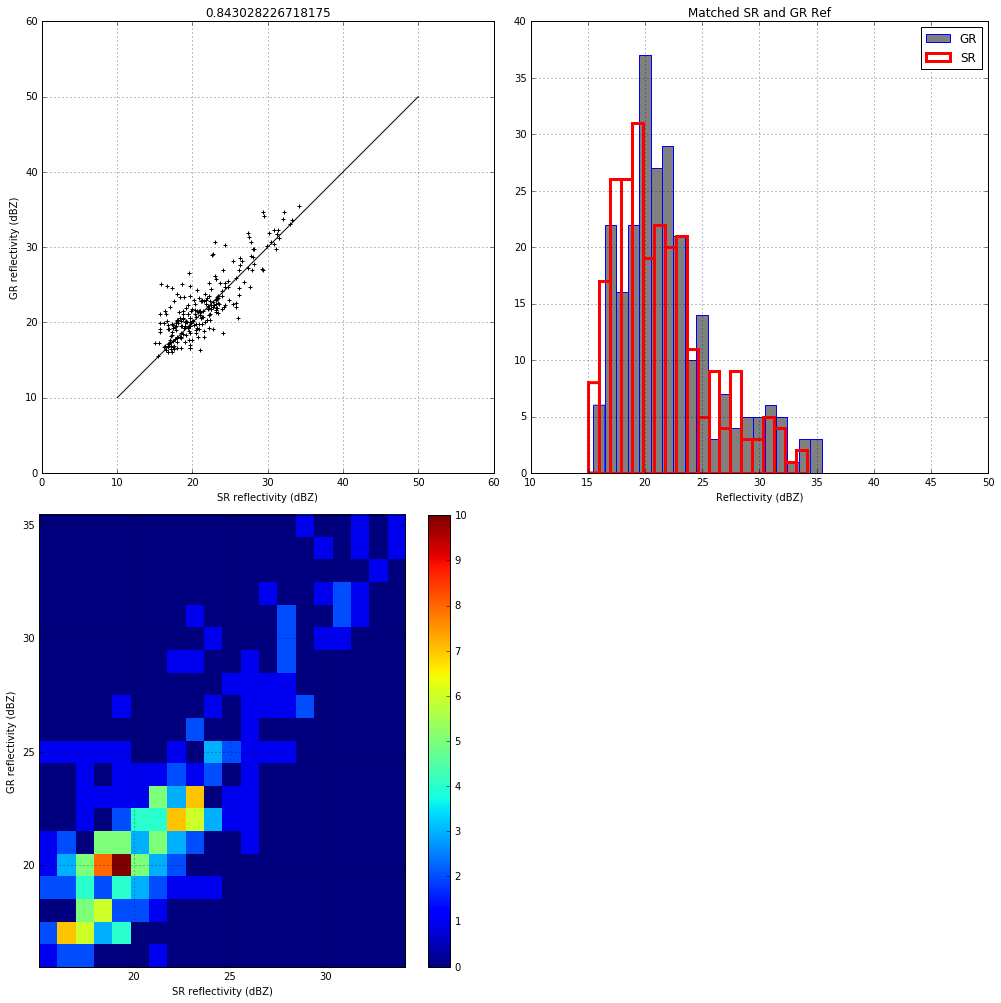

In [14]:
from satlib import corcor
from pcc import get_miub_cmap
TH = 15
SR[SR<=TH]=np.nan
GR[GR<=TH]=np.nan


fig = pl.figure(figsize=(14,14))
ax = fig.add_subplot(221, aspect="equal")
pl.scatter(SR, GR, marker="+", c="black")
pl.plot([10,50],[10,50], linestyle="solid", color="black")
#pl.xlim(10,50)
#pl.ylim(10,50)
pl.grid()
pl.ylabel("GR reflectivity (dBZ)")
pl.xlabel("SR reflectivity (dBZ)")
pl.title(corcor(GR, SR))

ax = fig.add_subplot(222)
m0 = ~np.isnan(GR)& ~np.isnan(SR)

pl.hist(GR[m0], bins=20, edgecolor="blue", facecolor="grey", label="GR")
pl.hist(SR[m0], bins=20, edgecolor="red", facecolor="None", label="SR", lw=3)
pl.xlabel("Reflectivity (dBZ)")
pl.legend()
pl.grid()
pl.title('Matched SR and GR Ref')
pl.xlim(10,50)

ax = fig.add_subplot(223)
pl.hist2d(SR[m0], GR[m0],bins=20)

pl.ylabel("GR reflectivity (dBZ)")
pl.xlabel("SR reflectivity (dBZ)")
pl.legend()
pl.grid()
pl.colorbar()
#pl.xlim(10,50)



pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/matching1.pdf')
pl.show()

('Corellation: ', '0.843028226718175')


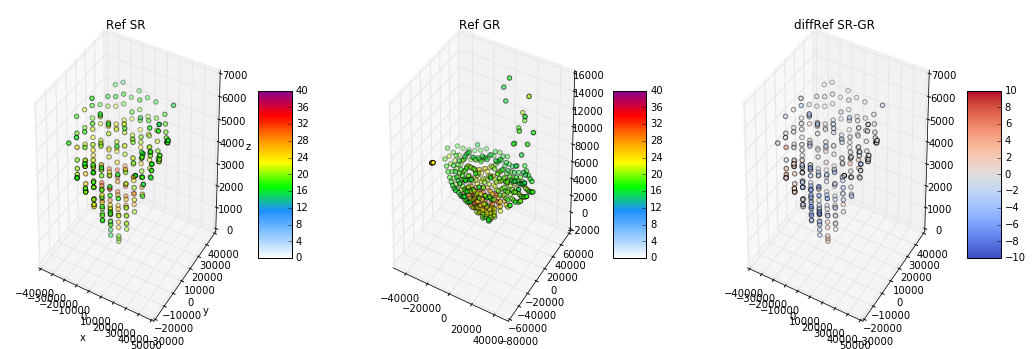

In [15]:
from mpl_toolkits.mplot3d import Axes3D
fig = pl.figure(figsize=(18,6))
ax1 = fig.add_subplot(131, projection='3d')
pppl = ax1.scatter(X, Y, Z, c=SR.ravel(), vmin=0, vmax=40, cmap=get_miub_cmap())
fig.colorbar(pppl, shrink=0.5, aspect=5)
ax1.set_title('Ref SR')
#ax1.set_xlim3d(-50000,50000)
#ax1.set_ylim3d(-50000,50000)
#ax1.set_zlim3d(0,50000)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")

ax2 = fig.add_subplot(132, projection='3d')
pppl = ax2.scatter(X, Y, Z, c=GR.ravel(), vmin=0, vmax=40, cmap=get_miub_cmap())
fig.colorbar(pppl, shrink=0.5, aspect=5)
ax2.set_title('Ref GR')

ax3 = fig.add_subplot(133, projection='3d')
pppl = ax3.scatter(X, Y, Z, c=SR.ravel()-GR.ravel(),
                   cmap='coolwarm',vmin=-10,vmax=10)
fig.colorbar(pppl, shrink=0.5, aspect=5)
ax3.set_title('diffRef SR-GR')

from satlib import corcor
print ('Corellation: ',corcor( SR, GR))
pl.savefig('/automount/ftp/velibor/validation/matching2.pdf')
pl.show()

In [16]:
"""fig = pl.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
print(xyz.shape, refsr1a.shape)
pppl = ax.scatter(gr_xyz[:,:,0], gr_xyz[:,:,1], gr_xyz[:,:,2],c=ref_gr, edgecolors='none', alpha=0.2)
pppl = ax.scatter(xyz[...,0],xyz[...,1],xyz[...,2], edgecolors='none', s=300, c='black')
ax.set_xlim(-10000, 10000)
ax.set_ylim(-10000, 10000)
ax.set_zlim(0, 2000)
pl.show()"""

"fig = pl.figure(figsize=(10,10))\nax = fig.add_subplot(111, projection='3d')\nprint(xyz.shape, refsr1a.shape)\npppl = ax.scatter(gr_xyz[:,:,0], gr_xyz[:,:,1], gr_xyz[:,:,2],c=ref_gr, edgecolors='none', alpha=0.2)\npppl = ax.scatter(xyz[...,0],xyz[...,1],xyz[...,2], edgecolors='none', s=300, c='black')\nax.set_xlim(-10000, 10000)\nax.set_ylim(-10000, 10000)\nax.set_zlim(0, 2000)\npl.show()"

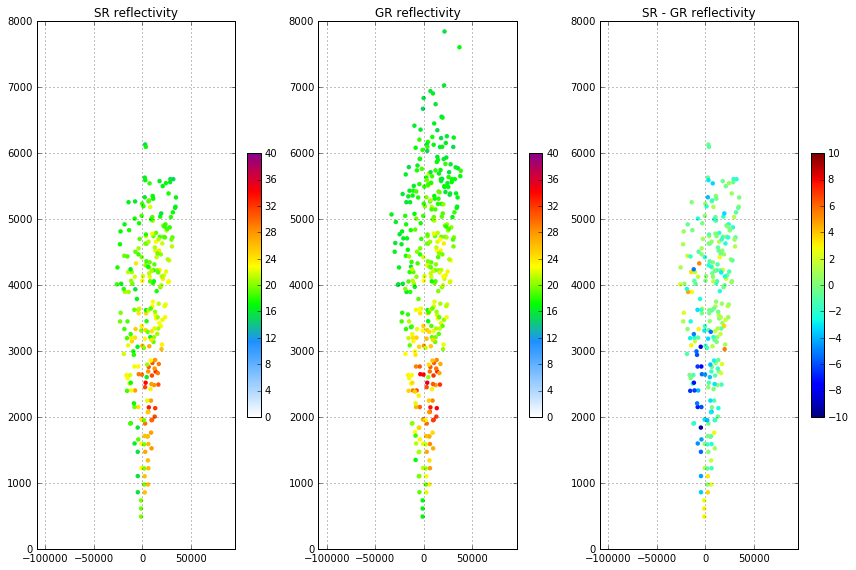

In [17]:
fig = pl.figure(figsize=(12,8))
ax = fig.add_subplot(131, aspect="auto")
pl.scatter(Y,Z, c=SR,  vmin=0, vmax=40, edgecolor="None", cmap=get_miub_cmap())
pl.title("SR reflectivity")
pl.xlim(np.nanmin(Y),np.nanmax(Y))
pl.ylim(0,8000)
pl.grid()
pl.colorbar(shrink=0.5)

ax = fig.add_subplot(132, aspect="auto")
pl.scatter(Y,Z, c=GR,  vmin=0, vmax=40, edgecolor="None", cmap=get_miub_cmap())
pl.title("GR reflectivity")
pl.xlim(np.nanmin(Y),np.nanmax(Y))
pl.ylim(0,8000)
pl.grid()
pl.colorbar(shrink=0.5)
#fig.suptitle("uncorrected GR vs uncorrected SR")
pl.tight_layout()

ax = fig.add_subplot(133, aspect="auto")
pl.scatter(Y,Z, c=SR-GR, cmap='jet',vmin=-10,vmax=10 ,edgecolor="None")
pl.title("SR - GR reflectivity")
pl.xlim(np.nanmin(Y),np.nanmax(Y))
pl.ylim(0,8000)
pl.grid()
pl.colorbar(shrink=0.5)
#fig.suptitle("uncorrected SR - GR")
pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/matching3.png')
pl.show()

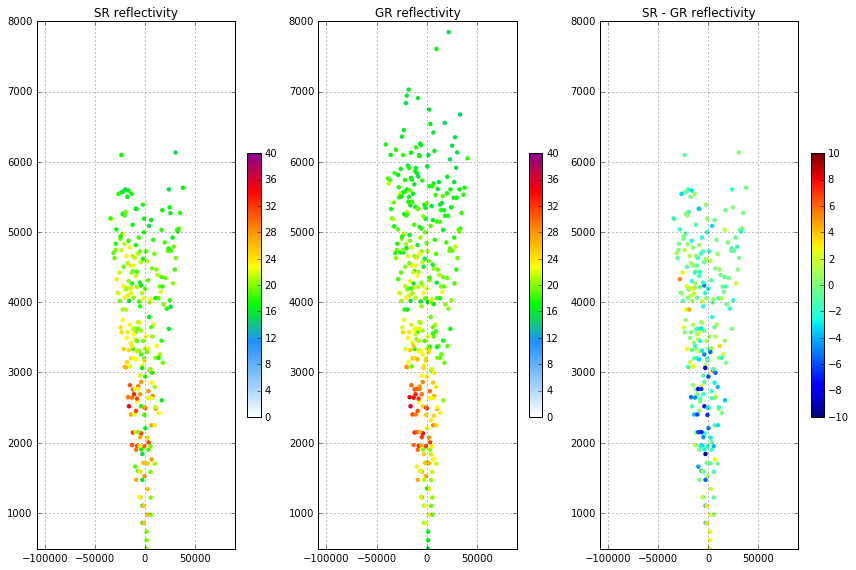

In [18]:
fig = pl.figure(figsize=(12,8))
ax = fig.add_subplot(131, aspect="auto")
pl.scatter(X,Z, c=SR, cmap=get_miub_cmap(), vmin=0, vmax=40, edgecolor="None")
pl.title("SR reflectivity")
pl.xlim(np.nanmin(X),np.nanmax(X))
pl.ylim(np.nanmin(Z),8000)
pl.grid()
pl.colorbar(shrink=0.5)

ax = fig.add_subplot(132, aspect="auto")
pl.scatter(X,Z, c=GR, cmap=get_miub_cmap(), vmin=0, vmax=40, edgecolor="None")
pl.title("GR reflectivity")
pl.xlim(np.nanmin(X),np.nanmax(X))
pl.ylim(np.nanmin(Z),8000)
pl.grid()
pl.colorbar(shrink=0.5)
#fig.suptitle("uncorrected GR vs uncorrected SR")
pl.tight_layout()

ax = fig.add_subplot(133, aspect="auto")
pl.scatter(X,Z, c=SR-GR, cmap='jet',vmin=-10,vmax=10 ,edgecolor="None")
pl.title("SR - GR reflectivity")
pl.xlim(np.nanmin(X),np.nanmax(X))
pl.ylim(np.nanmin(Z),8000)
pl.grid()
pl.colorbar(shrink=0.5)
#fig.suptitle("uncorrected SR - GR")
pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/matching4.pdf')
pl.show()

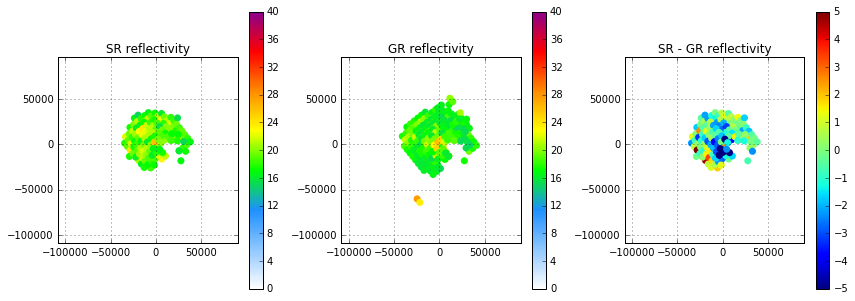

In [19]:
fig = pl.figure(figsize=(12,8))
ax = fig.add_subplot(131, aspect="equal")
pl.scatter(X,Y, c=SR, cmap=get_miub_cmap(), vmin=0, vmax=40, edgecolor="None",s=50)
pl.title("SR reflectivity")
pl.xlim(np.nanmin(X),np.nanmax(X))
pl.ylim(np.nanmin(Y),np.nanmax(Y))
pl.grid()
pl.colorbar(shrink=0.5)

ax = fig.add_subplot(132, aspect="equal")
pl.scatter(X,Y, c=GR, cmap=get_miub_cmap(), vmin=0, vmax=40, edgecolor="None",s=50)
pl.title("GR reflectivity")
pl.xlim(np.nanmin(X),np.nanmax(X))
pl.ylim(np.nanmin(Y),np.nanmax(Y))
pl.grid()
pl.colorbar(shrink=0.5)
#fig.suptitle("uncorrected GR vs uncorrected SR")
pl.tight_layout()

ax = fig.add_subplot(133, aspect="equal")
pl.scatter(X,Y, c=SR-GR, cmap='jet',vmin=-5,vmax=5 ,edgecolor="None",s=50)
pl.title("SR - GR reflectivity")
pl.xlim(np.nanmin(X),np.nanmax(X))
pl.ylim(np.nanmin(Y),np.nanmax(Y))
pl.grid()
pl.colorbar(shrink=0.5)
#fig.suptitle("uncorrected SR - GR")
pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/matching5.png')
pl.show()

In [20]:
def plot_cfad(x1, x2, ZP):
    """
    Plot 4 CFAD
    """
    import matplotlib.pyplot as plt
    m1 = ~np.isnan(x1) & ~np.isnan(x2)
    
    x3 = np.array([]); x4 = np.array([]); x5 = np.array([])

    hh = np.array([])
    for jj in range(0,20000,100):
        hh = np.append(hh,jj)
        x3 = np.append(x3,np.nanmean(x1[np.where((x2>jj)&(x2<jj+100))]))
        x4 = np.append(x4,np.nanmedian(x1[np.where((x2>jj)&(x2<jj+100))]))
    
    plt.figure(figsize=(12,12)) 
    plt.hexbin(x1[m1], x2[m1],bins=10, cmap='inferno')
    plt.colorbar()
    plt.xlabel('ZH in DBz')
    plt.ylabel('Height in m')
    plt.title('CFAD: '+ ZP)
    plt.plot(x3,hh, linewidth=2, label='mean')
    plt.plot(x4,hh, linewidth=2, label='median')
    plt.ylim(0,10000)
    plt.xlim(0,60)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(color='white')
    #plt.close()
    #plt.ylim(0,)
    #plt.show()



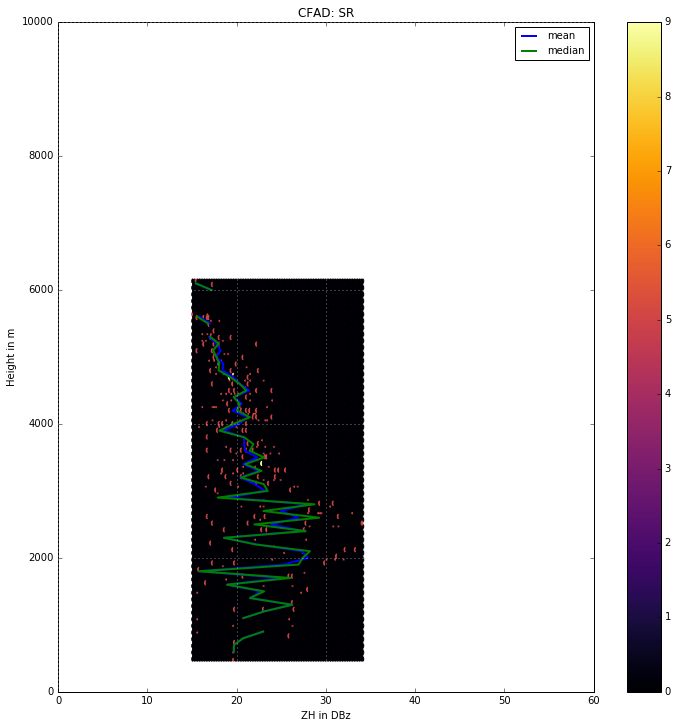

In [21]:
plot_cfad(SR,Z,'SR')
pl.savefig('/automount/ftp/velibor/validation/cfadSR.png')

pl.show()

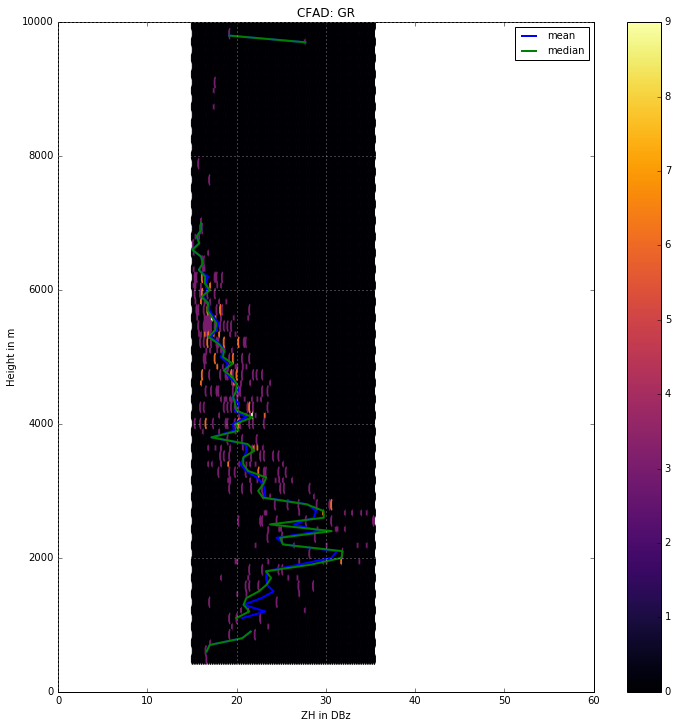

In [22]:
plot_cfad(GR,Z,'GR')
pl.savefig('/automount/ftp/velibor/validation/CFADGR.png')
pl.show()

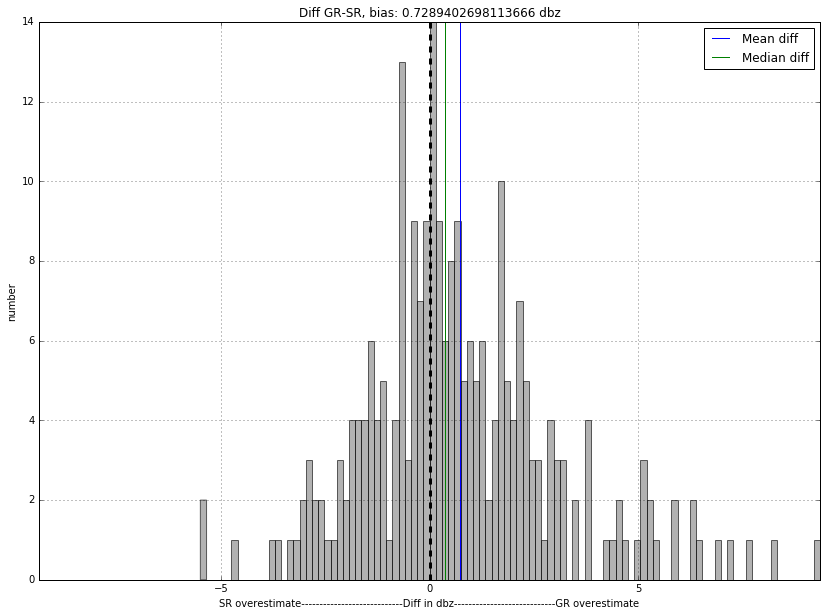

In [23]:
mm = ~np.isnan(GR)& ~np.isnan(SR)
pl.figure(figsize=(14,10))

pl.hist(GR[mm]-SR[mm],bins=100, facecolor="grey", alpha=0.6)
pl.axvline(np.mean(GR[mm]-SR[mm]), color='blue', label='Mean diff')
pl.axvline(np.median(GR[mm]-SR[mm]), color='green', label='Median diff')
pl.axvline(0, color='black',ls='--',lw=3)

xmin, xmax = np.nanmin(GR[mm]-SR[mm]), np.nanmax(GR[mm]-SR[mm])
limits = np.nanmax([abs(xmin),abs(xmax)])
pl.xlim(-limits,limits)

pl.title('Diff GR-SR, bias: '+str( np.sum(GR[mm]-SR[mm])/len(GR[mm]-SR[mm]))+' dbz')
pl.grid()
pl.legend()
pl.xlabel('SR overestimate----------------------------Diff in dbz----------------------------GR overestimate')
pl.ylabel('number')
pl.savefig('/automount/ftp/velibor/validation/matching_bias.pdf')
pl.show()

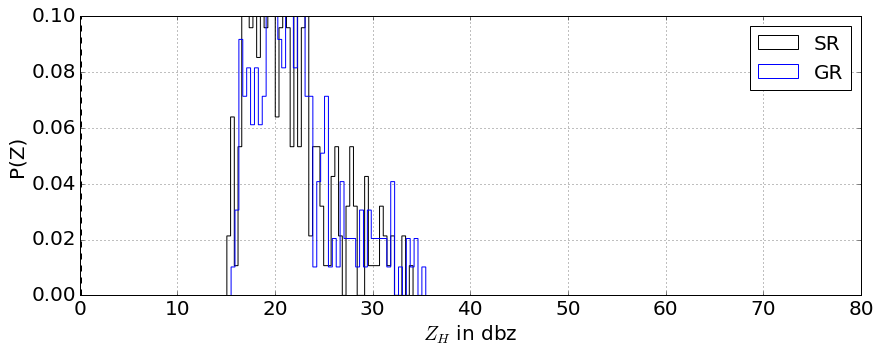

In [24]:

mm = ~np.isnan(GR) & ~np.isnan(SR)
#m2 = 

pl.figure(figsize=(14,5))
pl.hist(SR[mm],bins=50, facecolor="None", alpha=1, edgecolor='black', histtype='step', label='SR', normed=1)
pl.xlim(left=0)


pl.hist(GR[mm],bins=50, facecolor="None", alpha=1, edgecolor='blue', histtype='step', label='GR', normed=1)
pl.axvline(0, color='black',ls='--',lw=3)


pl.grid()
pl.legend(fontsize=20)
#pl.ylim(top=90)
pl.ylabel('P(Z)', fontsize=20)
pl.xlabel(r'$Z_H$ in dbz', fontsize=20)
pl.xticks(fontsize=20); pl.yticks(fontsize=20)
pl.xlim(0,80); pl.ylim(0,0.1)
pl.savefig('/automount/ftp/velibor/validation/matching_hist.pdf')
pl.savefig('/automount/ftp/velibor/validation/matching_hist.png')
pl.show()

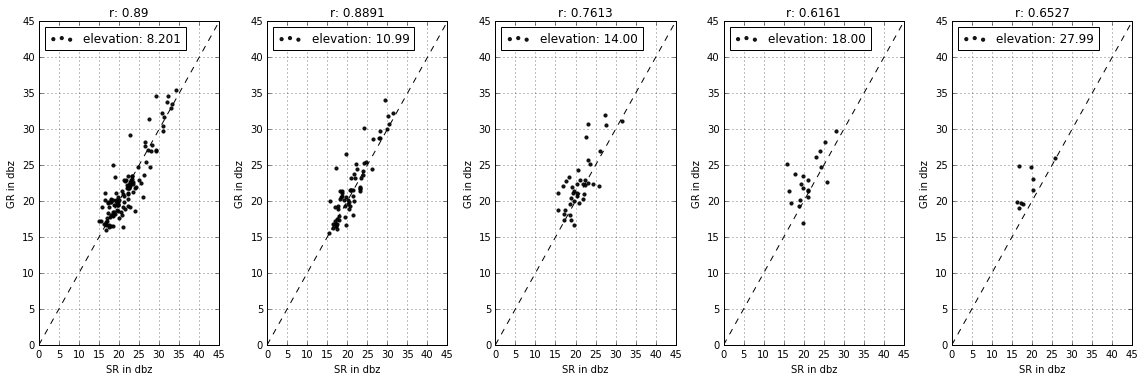

In [25]:
aa=0.9
# Elevation unterteilen mit Cumulativer Summe
e_pos = gr_nr_elev.cumsum().astype(int)

pl.figure(figsize=(16,10))

for eee in range(len(gr_nr_elev)):
    pl.subplot(2,5,eee+1)
    
    if eee==0: 
        pl.scatter(SR[0:e_pos[0]],GR[0:e_pos[0]],alpha=aa,label='elevation: '+str(gr_ele[0])[0:5],color='black',s=10)
        pl.title('r: ' + corcor(SR[0:e_pos[0]],GR[0:e_pos[0]])[0:4])
        pl.legend(loc='upper left')
    else:
        pl.scatter(SR[e_pos[eee-1]:e_pos[eee]],GR[e_pos[eee-1]:e_pos[eee]],alpha=aa,
                   label='elevation: ' + str(gr_ele[eee])[0:5],color='black',s=10)
        pl.title('r: ' + corcor(SR[e_pos[eee-1]:e_pos[eee]],GR[e_pos[eee-1]:e_pos[eee]])[0:6])
        pl.legend(loc='upper left')
    pl.xlabel('SR in dbz')
    pl.ylabel('GR in dbz')
    pl.grid()
    pl.xlim(0,45)
    pl.ylim(0,45)
    pl.plot([0,45],[0,45], color='black', ls='--')

pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/corr_elev.pdf')
pl.show()

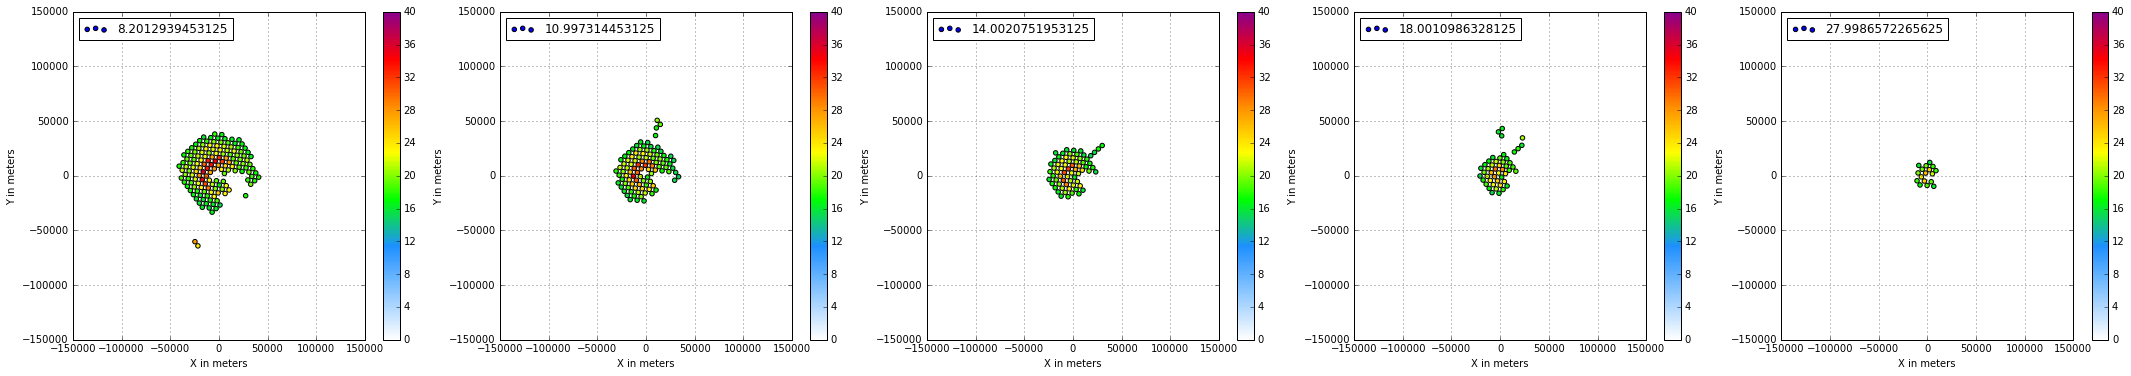

In [26]:
# Elevation unterteilen mit Cumulativer Summe
e_pos = gr_nr_elev.cumsum().astype(int)
from pcc import get_miub_cmap

pl.figure(figsize=(30,10))

for eee in range(len(gr_nr_elev)):
    pl.subplot(2,5,eee+1)
    
    if eee==0: 
        pl.scatter(X[0:e_pos[0]],Y[0:e_pos[0]],c=GR[0:e_pos[0]],label=str(gr_ele[0]),
                   cmap=get_miub_cmap(), vmin=0, vmax=40)
        pl.legend(loc='upper left')
    else:
        pl.scatter(X[e_pos[eee-1]:e_pos[eee]],Y[e_pos[eee-1]:e_pos[eee]],c=GR[e_pos[eee-1]:e_pos[eee]],
                   label=str(gr_ele[eee]), cmap=get_miub_cmap(), vmin=0, vmax=40)
        pl.legend(loc='upper left')
    pl.xlabel('X in meters')
    pl.ylabel('Y in meters')
    pl.grid()
    pl.xlim(-150000,150000)
    pl.ylim(-150000,150000)
    pl.colorbar()


pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/match_ppiGR.pdf')
pl.savefig('/automount/ftp/velibor/validation/match_ppiGR.png')


pl.show()

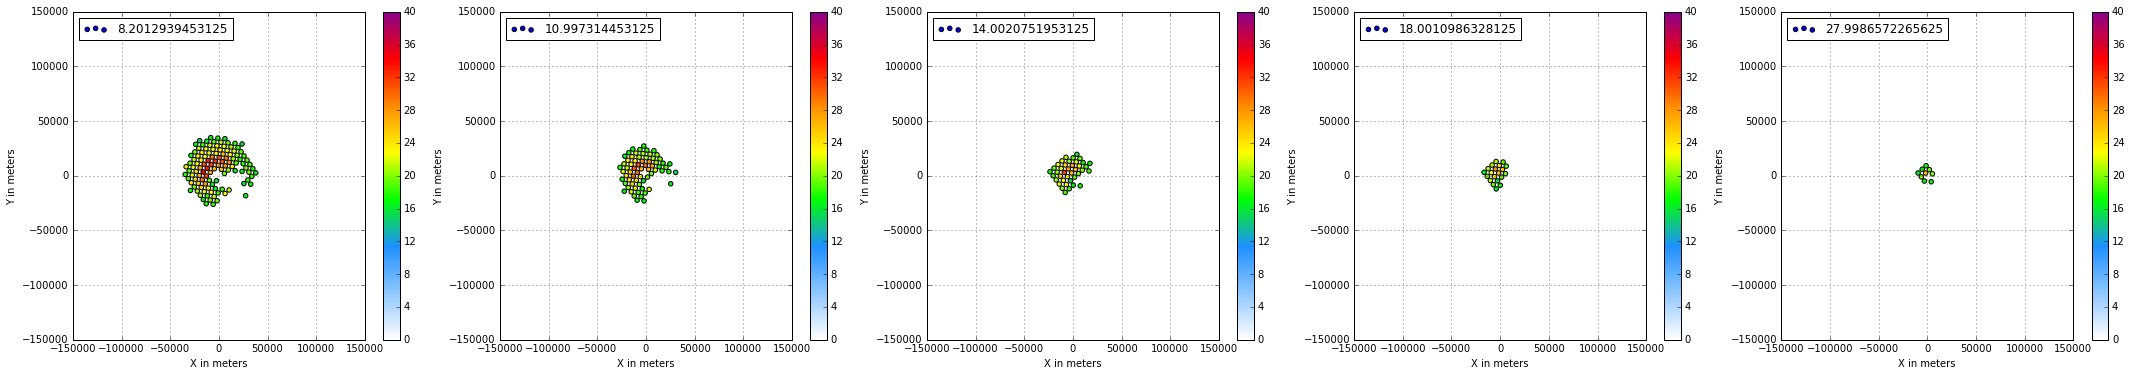

In [27]:
# Elevation unterteilen mit Cumulativer Summe
e_pos = gr_nr_elev.cumsum().astype(int)
from pcc import get_miub_cmap

pl.figure(figsize=(30,10))

for eee in range(len(gr_nr_elev)):
    pl.subplot(2,5,eee+1)
    
    if eee==0: 
        pl.scatter(X[0:e_pos[0]],Y[0:e_pos[0]],c=SR[0:e_pos[0]],label=str(gr_ele[0]),
                   cmap=get_miub_cmap(), vmin=0, vmax=40)
        pl.legend(loc='upper left')
    else:
        pl.scatter(X[e_pos[eee-1]:e_pos[eee]],Y[e_pos[eee-1]:e_pos[eee]],c=SR[e_pos[eee-1]:e_pos[eee]],
                   label=str(gr_ele[eee]), cmap=get_miub_cmap(), vmin=0, vmax=40)
        pl.legend(loc='upper left')
    pl.xlabel('X in meters')
    pl.ylabel('Y in meters')
    pl.grid()
    pl.xlim(-150000,150000)
    pl.ylim(-150000,150000)
    pl.colorbar()


pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/match_ppiSR.pdf')
pl.savefig('/automount/ftp/velibor/validation/match_ppiSR.png')


pl.show()

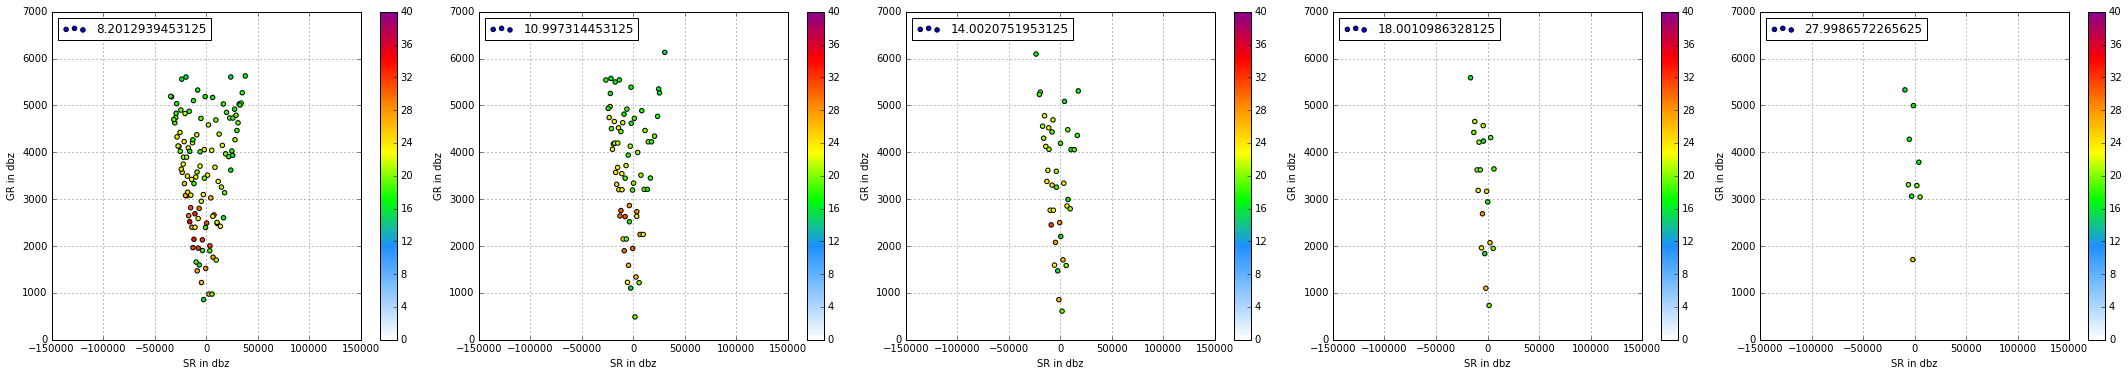

In [28]:
# Elevation unterteilen mit Cumulativer Summe
e_pos = gr_nr_elev.cumsum().astype(int)
from pcc import get_miub_cmap

pl.figure(figsize=(30,10))

for eee in range(len(gr_nr_elev)):
    pl.subplot(2,5,eee+1)
    
    if eee==0: 
        pl.scatter(X[0:e_pos[0]],Z[0:e_pos[0]],c=SR[0:e_pos[0]],label=str(gr_ele[0]),
                   cmap=get_miub_cmap(), vmin=0, vmax=40)
        pl.legend(loc='upper left')
    else:
        pl.scatter(X[e_pos[eee-1]:e_pos[eee]],Z[e_pos[eee-1]:e_pos[eee]],c=SR[e_pos[eee-1]:e_pos[eee]],
                   label=str(gr_ele[eee]), cmap=get_miub_cmap(), vmin=0, vmax=40)
        pl.legend(loc='upper left')
    pl.xlabel('SR in dbz')
    pl.ylabel('GR in dbz')
    pl.grid()
    pl.xlim(-150000,150000)
    pl.ylim(0,7000)
    pl.colorbar()


pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/match_XppiSR.png')

pl.show()

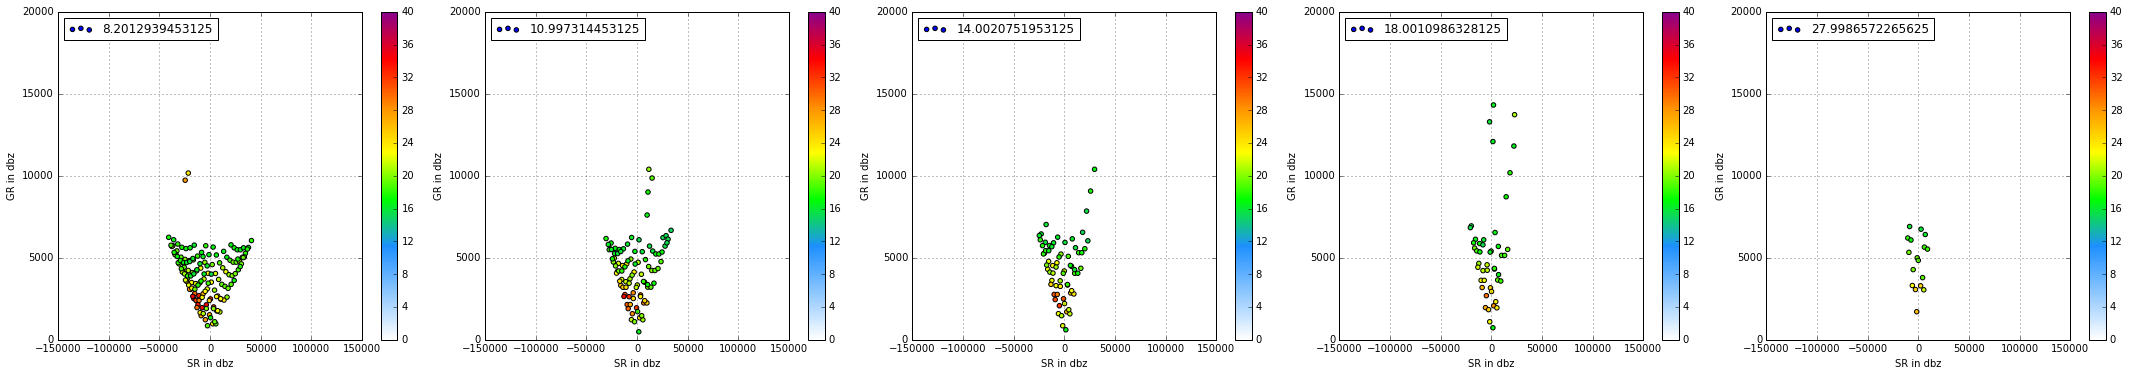

In [29]:
# Elevation unterteilen mit Cumulativer Summe
e_pos = gr_nr_elev.cumsum().astype(int)
from pcc import get_miub_cmap

pl.figure(figsize=(30,10))

for eee in range(len(gr_nr_elev)):
    pl.subplot(2,5,eee+1)
    
    if eee==0: 
        pl.scatter(X[0:e_pos[0]],Z[0:e_pos[0]],c=GR[0:e_pos[0]],label=str(gr_ele[0]),
                   cmap=get_miub_cmap(), vmin=0, vmax=40)
        pl.legend(loc='upper left')
    else:
        pl.scatter(X[e_pos[eee-1]:e_pos[eee]],Z[e_pos[eee-1]:e_pos[eee]],c=GR[e_pos[eee-1]:e_pos[eee]],
                   label=str(gr_ele[eee]), cmap=get_miub_cmap(), vmin=0, vmax=40)
        pl.legend(loc='upper left')
    pl.xlabel('SR in dbz')
    pl.ylabel('GR in dbz')
    pl.grid()
    pl.xlim(-150000,150000)
    pl.ylim(0,20000)
    pl.colorbar()


pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/match_XppiGR.pdf')

pl.show()

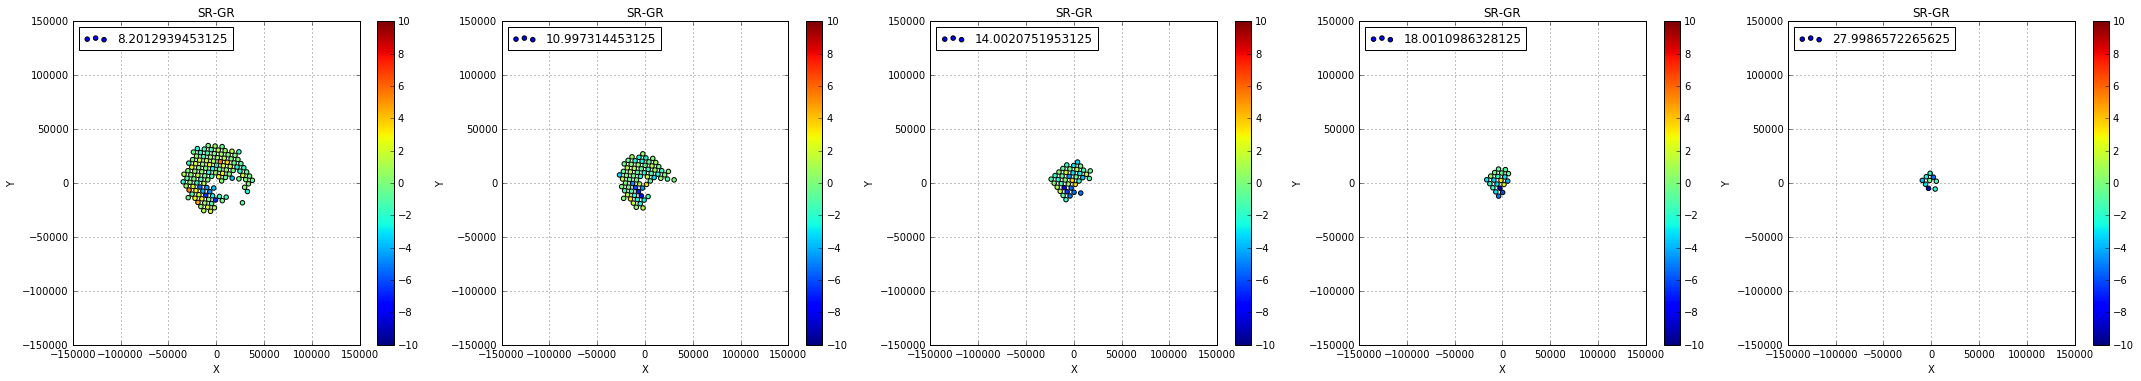

In [30]:
# Elevation unterteilen mit Cumulativer Summe
e_pos = gr_nr_elev.cumsum().astype(int)
from pcc import get_miub_cmap

pl.figure(figsize=(30,10))

for eee in range(len(gr_nr_elev)):
    pl.subplot(2,5,eee+1)
    
    if eee==0: 
        pl.scatter(X[0:e_pos[0]],Y[0:e_pos[0]],c=SR[0:e_pos[0]]-GR[0:e_pos[0]],label=str(gr_ele[0]),
                   cmap='jet', vmin=-10, vmax=10)
        pl.legend(loc='upper left')
    else:
        pl.scatter(X[e_pos[eee-1]:e_pos[eee]],Y[e_pos[eee-1]:e_pos[eee]],c=SR[e_pos[eee-1]:e_pos[eee]]-GR[e_pos[eee-1]:e_pos[eee]],
                   label=str(gr_ele[eee]), cmap='jet', vmin=-10, vmax=10)
        pl.legend(loc='upper left')
    pl.xlabel('X')
    pl.ylabel('Y')
    pl.title('SR-GR')
    pl.grid()
    pl.xlim(-150000,150000)
    pl.ylim(-150000,150000)
    pl.colorbar()


pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/match_ppiSR.png')

pl.show()

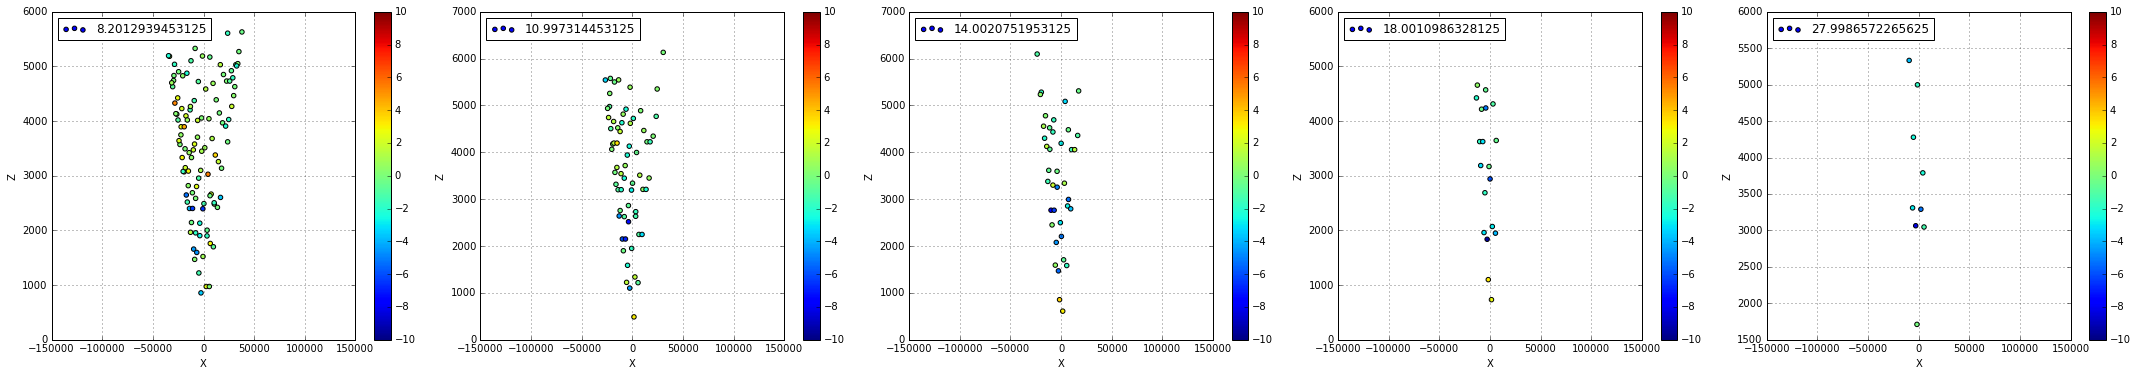

In [31]:
# Elevation unterteilen mit Cumulativer Summe
e_pos = gr_nr_elev.cumsum().astype(int)
from pcc import get_miub_cmap

pl.figure(figsize=(30,10))

for eee in range(len(gr_nr_elev)):
    pl.subplot(2,5,eee+1)
    
    if eee==0: 
        pl.scatter(X[0:e_pos[0]],Z[0:e_pos[0]],c=SR[0:e_pos[0]]-GR[0:e_pos[0]],label=str(gr_ele[0]),
                   cmap='jet', vmin=-10, vmax=10)
        pl.legend(loc='upper left')
    else:
        pl.scatter(X[e_pos[eee-1]:e_pos[eee]],Z[e_pos[eee-1]:e_pos[eee]],c=SR[e_pos[eee-1]:e_pos[eee]]-GR[e_pos[eee-1]:e_pos[eee]],
                   label=str(gr_ele[eee]), cmap='jet', vmin=-10, vmax=10)
        pl.legend(loc='upper left')
    pl.xlabel('X')
    pl.ylabel('Z')
    pl.grid()
    pl.xlim(-150000,150000)
    #pl.ylim(0,7000)
    pl.colorbar()


pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/match_XppiSR.pdf')
pl.show()


In [32]:
def subplot_cfad(x1, x2, ZP):
    """
    Plot 4 CFAD
    """
    import matplotlib.pyplot as plt
    m1 = ~np.isnan(x1) & ~np.isnan(x2)
    
    x3 = np.array([]); x4 = np.array([]); x5 = np.array([])

    hh = np.array([])
    for jj in range(0,20000,100):
        hh = np.append(hh,jj)
        x3 = np.append(x3,np.nanmean(x1[np.where((x2>jj)&(x2<jj+100))]))
        x4 = np.append(x4,np.nanmedian(x1[np.where((x2>jj)&(x2<jj+100))]))
    
    plt.hexbin(x1[m1], x2[m1],bins=10, cmap='inferno')
    plt.colorbar()
    plt.xlabel('ZH in DBz')
    plt.ylabel('Height in m')
    plt.title('CFAD: '+ ZP)
    plt.plot(x3,hh, linewidth=2, label='mean')
    plt.plot(x4,hh, linewidth=2, label='median')

    plt.legend(loc='upper right', fontsize=10)
    plt.grid(color='white')
    #plt.close()
    #plt.ylim(0,)
    #plt.show()



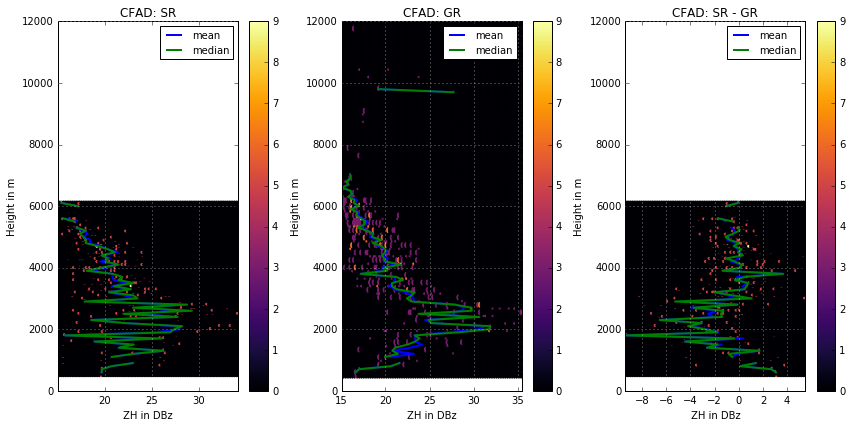

In [33]:
diff_SRGR = SR - GR
pl.figure(figsize=(12,6)) 
pl.subplot(1,3,1)
subplot_cfad(SR,Z,'SR')
pl.ylim(0,12000)
pl.subplot(1,3,2)
subplot_cfad(GR,Z,'GR')
pl.ylim(0,12000)
pl.subplot(1,3,3)
subplot_cfad(diff_SRGR,Z,'SR - GR')
pl.ylim(0,12000)

pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/cfad_SR_GR.pdf')
pl.show()

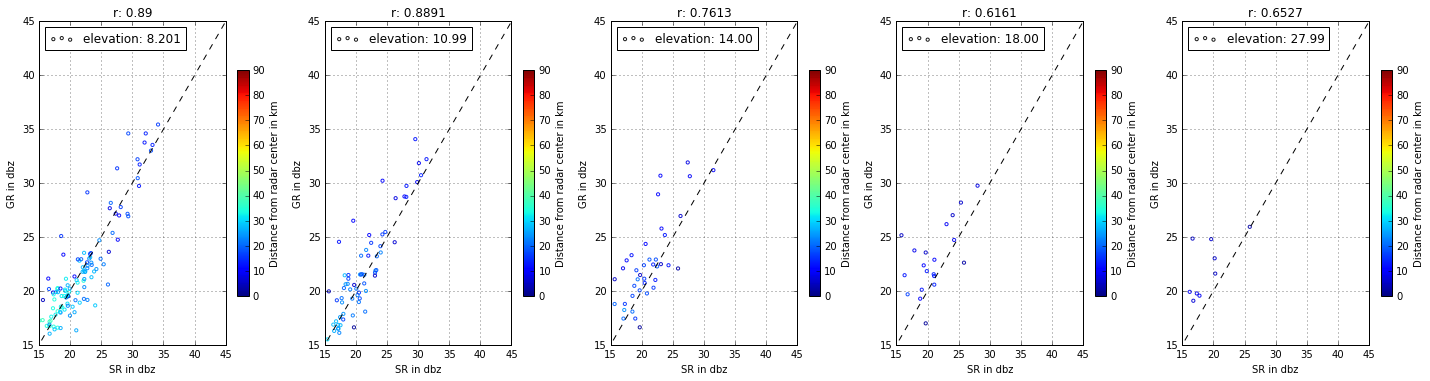

In [34]:
x1, x2 = 0, X
y1, y2 = 0, Y

dist = np.hypot(x2 - x1, y2 - y1)

dist = dist/1000.

aa=0.9
# Elevation unterteilen mit Cumulativer Summe
e_pos = gr_nr_elev.cumsum().astype(int)

pl.figure(figsize=(20,10))

for eee in range(len(gr_nr_elev)):
    pl.subplot(2,5,eee+1)
    
    if eee==0: 
        sc = pl.scatter(SR[0:e_pos[0]],
                   GR[0:e_pos[0]],
                   c=dist[0:e_pos[0]],
                   alpha=aa,label='elevation: '+str(gr_ele[0])[0:5],
                   color='black',
                   s=10,
                   vmin=0.,
                   vmax=90,
                   marker='o')
        sc.set_facecolor("none")
        pl.title('r: ' + corcor(SR[0:e_pos[0]],GR[0:e_pos[0]])[0:4])
        pl.legend(loc='upper left')
        cbar = pl.colorbar(shrink=0.7)
        cbar.ax.set_ylabel('Distance from radar center in km', fontsize=10)
        
    else:
        sc = pl.scatter(SR[e_pos[eee-1]:e_pos[eee]],
                   GR[e_pos[eee-1]:e_pos[eee]],
                   c=dist[e_pos[eee-1]:e_pos[eee]],
                   vmin = 0.,
                   vmax = 90.,
                   alpha=aa,
                   label='elevation: ' + str(gr_ele[eee])[0:5],
                   color='black',
                   s=10,
                   marker='o')
        sc.set_facecolor("none")
        pl.title('r: ' + corcor(SR[e_pos[eee-1]:e_pos[eee]],GR[e_pos[eee-1]:e_pos[eee]])[0:6])
        pl.legend(loc='upper left')
        cbar = pl.colorbar(shrink=0.7)
        cbar.ax.set_ylabel('Distance from radar center in km', fontsize=10)
        
    pl.xlabel('SR in dbz')
    pl.ylabel('GR in dbz')
    pl.grid()
    pl.xlim(15,45)
    pl.ylim(15,45)
    pl.plot([0,45],[0,45], color='black', ls='--')

pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/corr_elev_dist.pdf')
pl.show()

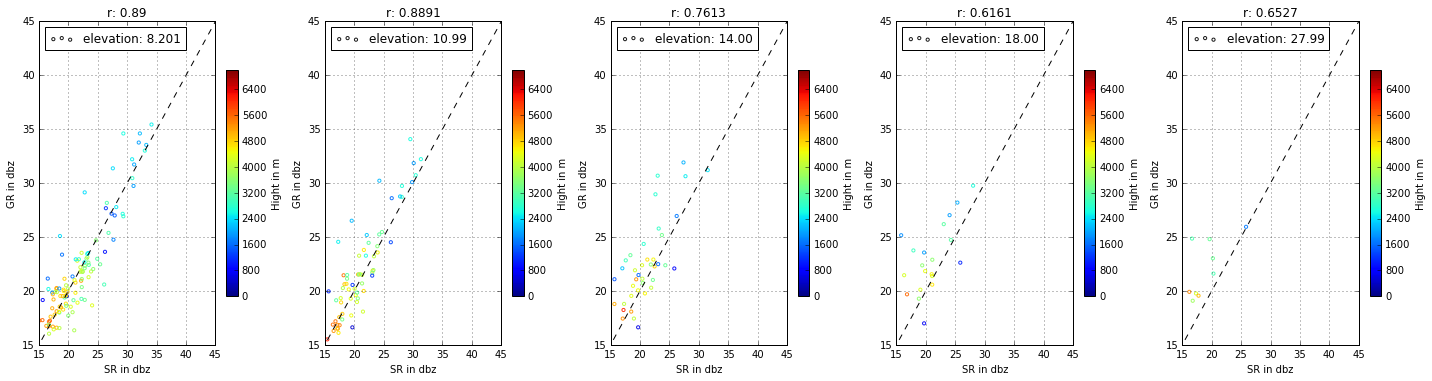

In [35]:
x1, x2 = 0, X
y1, y2 = 0, Y

dist = np.hypot(x2 - x1, y2 - y1)

dist = dist/1000.

aa=0.9
# Elevation unterteilen mit Cumulativer Summe
e_pos = gr_nr_elev.cumsum().astype(int)

pl.figure(figsize=(20,10))

for eee in range(len(gr_nr_elev)):
    pl.subplot(2,5,eee+1)
    
    if eee==0: 
        sc = pl.scatter(SR[0:e_pos[0]],
                   GR[0:e_pos[0]],
                   c=Z[0:e_pos[0]],
                   alpha=aa,label='elevation: '+str(gr_ele[0])[0:5],
                   color='black',
                   s=10,
                   vmin=0.,
                   vmax=7000,
                   marker='o')
        sc.set_facecolor("none")
        pl.title('r: ' + corcor(SR[0:e_pos[0]],GR[0:e_pos[0]])[0:4])
        pl.legend(loc='upper left')
        cbar = pl.colorbar(shrink=0.7)
        cbar.ax.set_ylabel('Hight in m', fontsize=10)
        
    else:
        sc = pl.scatter(SR[e_pos[eee-1]:e_pos[eee]],
                   GR[e_pos[eee-1]:e_pos[eee]],
                   c=Z[e_pos[eee-1]:e_pos[eee]],
                   vmin = 0.,
                   vmax = 7000.,
                   alpha=aa,
                   label='elevation: ' + str(gr_ele[eee])[0:5],
                   color='black',
                   s=10,
                   marker='o')
        sc.set_facecolor("none")
        pl.title('r: ' + corcor(SR[e_pos[eee-1]:e_pos[eee]],GR[e_pos[eee-1]:e_pos[eee]])[0:6])
        pl.legend(loc='upper left')
        cbar = pl.colorbar(shrink=0.7)
        cbar.ax.set_ylabel('Hight in m', fontsize=10)
        
    pl.xlabel('SR in dbz')
    pl.ylabel('GR in dbz')
    pl.grid()
    pl.xlim(15,45)
    pl.ylim(15,45)
    pl.plot([0,45],[0,45], color='black', ls='--')

pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/corr_elev_hight.pdf')
pl.show()

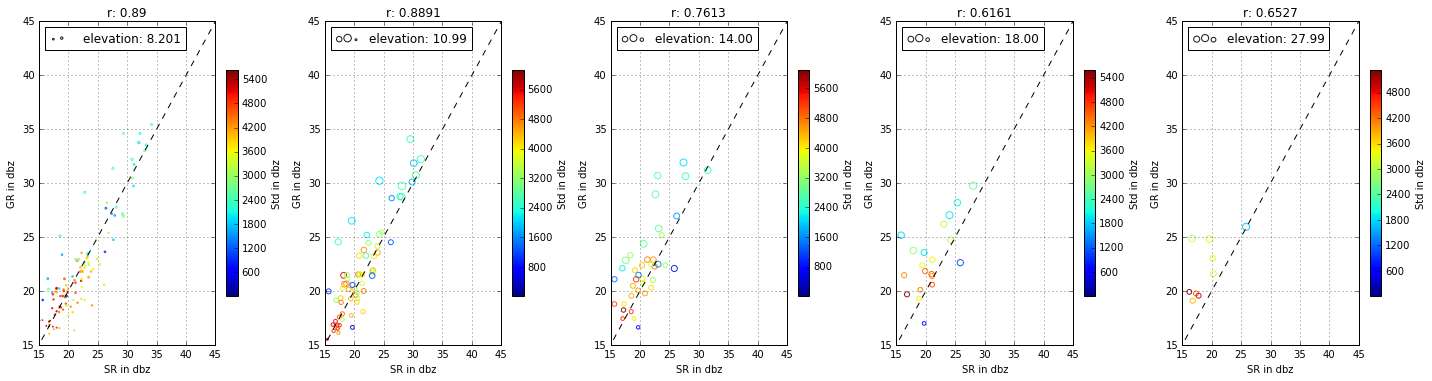

In [36]:
x1, x2 = 0, X
y1, y2 = 0, Y

dist = np.hypot(x2 - x1, y2 - y1)

dist = dist/10000.

aa=0.9
# Elevation unterteilen mit Cumulativer Summe
e_pos = gr_nr_elev.cumsum().astype(int)

pl.figure(figsize=(20,10))

for eee in range(len(gr_nr_elev)):
    pl.subplot(2,5,eee+1)
    
    if eee==0: 
        sc = pl.scatter(SR[0:e_pos[0]],
                   GR[0:e_pos[0]],
                   c=Z[0:e_pos[0]],
                   alpha=aa,label='elevation: '+str(gr_ele[0])[0:5],
                   color='black',
                   s=10*GRstd[0:e_pos[0]]/10,
                   vmin=1.,
                   #vmax=25,
                   marker='o')
        sc.set_facecolor("none")
        pl.title('r: ' + corcor(SR[0:e_pos[0]],GR[0:e_pos[0]])[0:4])
        pl.legend(loc='upper left')
        cbar = pl.colorbar(shrink=0.7)
        cbar.ax.set_ylabel('Std in dbz', fontsize=10)
        
    else:
        sc = pl.scatter(SR[e_pos[eee-1]:e_pos[eee]],
                   GR[e_pos[eee-1]:e_pos[eee]],
                   c=Z[e_pos[eee-1]:e_pos[eee]],
                   vmin = 1.,
                   #vmax = 25.,
                   alpha=aa,
                   label='elevation: ' + str(gr_ele[eee])[0:5],
                   color='black',
                   s=10*GRstd[e_pos[eee-1]:e_pos[eee]],
                   marker='o')
        sc.set_facecolor("none")
        pl.title('r: ' + corcor(SR[e_pos[eee-1]:e_pos[eee]],GR[e_pos[eee-1]:e_pos[eee]])[0:6])
        pl.legend(loc='upper left')
        cbar = pl.colorbar(shrink=0.7)
        cbar.ax.set_ylabel('Std in dbz', fontsize=10)
        
    pl.xlabel('SR in dbz')
    pl.ylabel('GR in dbz')
    pl.grid()
    pl.xlim(15,45)
    pl.ylim(15,45)
    pl.plot([0,45],[0,45], color='black', ls='--')

pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/corr_elev_hight_std.pdf')
pl.savefig('/automount/ftp/velibor/validation/corr_elev_hight_std.png')
pl.show()

In [37]:
np.log(np.unique(Z))

array([6.19236071, 6.41550426, 6.59782582, ..., 9.89928148, 9.90240179,
       9.90419426])

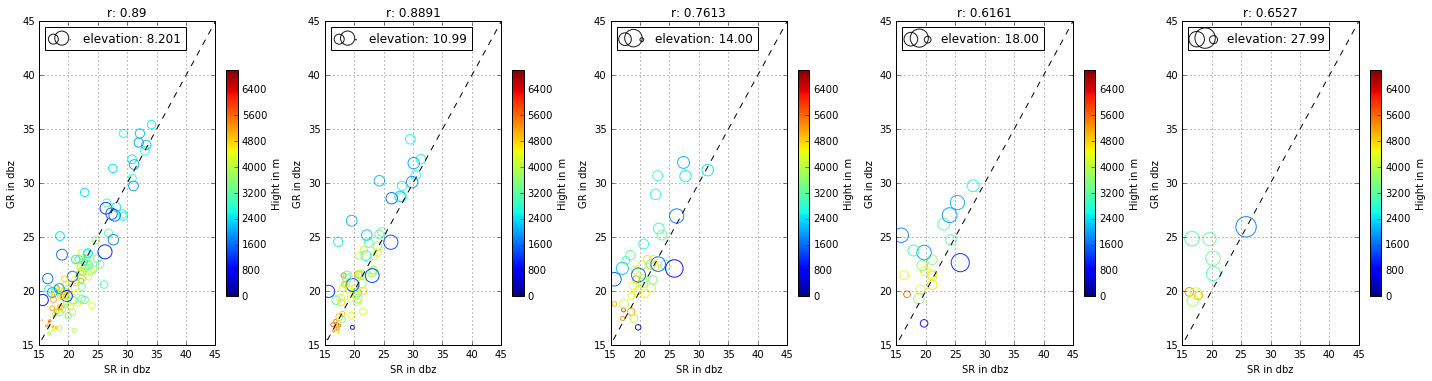

In [38]:
x1, x2 = 0, X
y1, y2 = 0, Y

dist = np.hypot(x2 - x1, y2 - y1)

dist = dist/10000.

aa=0.9
# Elevation unterteilen mit Cumulativer Summe
e_pos = gr_nr_elev.cumsum().astype(int)

pl.figure(figsize=(20,10))

for eee in range(len(gr_nr_elev)):
    pl.subplot(2,5,eee+1)
    
    if eee==0: 
        sc = pl.scatter(SR[0:e_pos[0]],
                   GR[0:e_pos[0]],
                   c=Z[0:e_pos[0]],
                   alpha=aa,label='elevation: '+str(gr_ele[0])[0:5],
                   color='black',
                   s=GRnum[0:e_pos[0]]/10,
                   vmin=0.,
                   vmax=7000,
                   marker='o')
        sc.set_facecolor("none")
        pl.title('r: ' + corcor(SR[0:e_pos[0]],GR[0:e_pos[0]])[0:4])
        pl.legend(loc='upper left')
        cbar = pl.colorbar(shrink=0.7)
        cbar.ax.set_ylabel('Hight in m', fontsize=10)
        
    else:
        sc = pl.scatter(SR[e_pos[eee-1]:e_pos[eee]],
                   GR[e_pos[eee-1]:e_pos[eee]],
                   c=Z[e_pos[eee-1]:e_pos[eee]],
                   vmin = 0.,
                   vmax = 7000.,
                   alpha=aa,
                   label='elevation: ' + str(gr_ele[eee])[0:5],
                   color='black',
                   s=GRnum[e_pos[eee-1]:e_pos[eee]]/10,
                   marker='o')
        sc.set_facecolor("none")
        pl.title('r: ' + corcor(SR[e_pos[eee-1]:e_pos[eee]],GR[e_pos[eee-1]:e_pos[eee]])[0:6])
        pl.legend(loc='upper left')
        cbar = pl.colorbar(shrink=0.7)
        cbar.ax.set_ylabel('Hight in m', fontsize=10)
        
    pl.xlabel('SR in dbz')
    pl.ylabel('GR in dbz')
    pl.grid()
    pl.xlim(15,45)
    pl.ylim(15,45)
    pl.plot([0,45],[0,45], color='black', ls='--')

pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/corr_elev_hight_num.pdf')
pl.savefig('/automount/ftp/velibor/validation/corr_elev_hight_num.png')
pl.show()

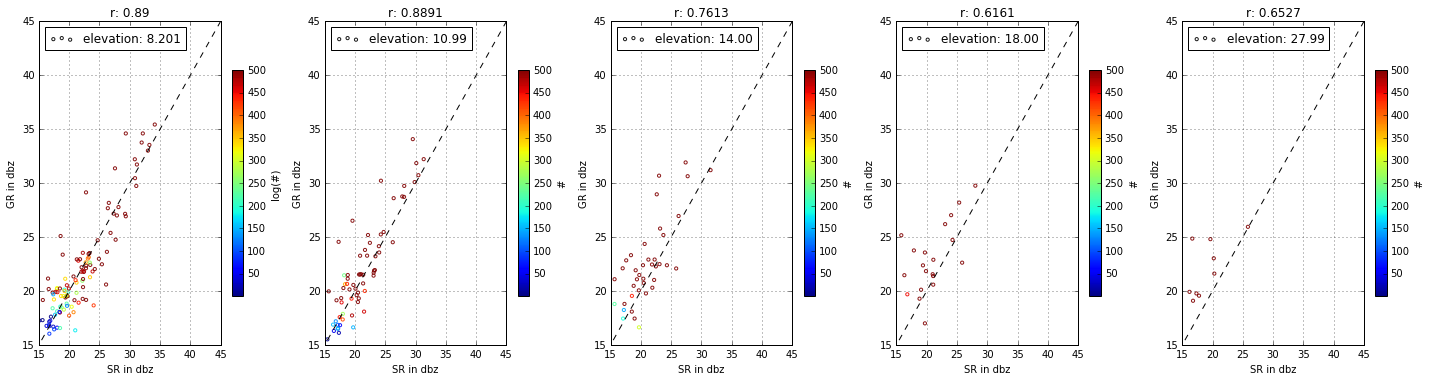

In [39]:
x1, x2 = 0, X
y1, y2 = 0, Y

dist = np.hypot(x2 - x1, y2 - y1)

dist = dist/10000.

aa=0.9
# Elevation unterteilen mit Cumulativer Summe
e_pos = gr_nr_elev.cumsum().astype(int)

pl.figure(figsize=(20,10))

for eee in range(len(gr_nr_elev)):
    pl.subplot(2,5,eee+1)
    
    if eee==0: 
        sc = pl.scatter(SR[0:e_pos[0]],
                   GR[0:e_pos[0]],
                   c=GRnum[0:e_pos[0]],
                   alpha=aa,label='elevation: '+str(gr_ele[0])[0:5],
                   color='black',
                   s=10,
                   vmin=0.1,
                   vmax=500,
                   marker='o')
        sc.set_facecolor("none")
        pl.title('r: ' + corcor(SR[0:e_pos[0]],GR[0:e_pos[0]])[0:4])
        pl.legend(loc='upper left')
        cbar = pl.colorbar(shrink=0.7)
        cbar.ax.set_ylabel('log(#)', fontsize=10)
        
    else:
        sc = pl.scatter(SR[e_pos[eee-1]:e_pos[eee]],
                   GR[e_pos[eee-1]:e_pos[eee]],
                   c=GRnum[e_pos[eee-1]:e_pos[eee]],
                   vmin = 0.1,
                   vmax = 500.,
                   alpha=aa,
                   label='elevation: ' + str(gr_ele[eee])[0:5],
                   color='black',
                   s=10,
                   marker='o')
        sc.set_facecolor("none")
        pl.title('r: ' + corcor(SR[e_pos[eee-1]:e_pos[eee]],GR[e_pos[eee-1]:e_pos[eee]])[0:6])
        pl.legend(loc='upper left')
        cbar = pl.colorbar(shrink=0.7)
        cbar.ax.set_ylabel('#', fontsize=10)
        
    pl.xlabel('SR in dbz')
    pl.ylabel('GR in dbz')
    pl.grid()
    pl.xlim(15,45)
    pl.ylim(15,45)
    pl.plot([0,45],[0,45], color='black', ls='--')

pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/corr_elev_num.pdf')
pl.savefig('/automount/ftp/velibor/validation/corr_elev_num.png')
pl.show()

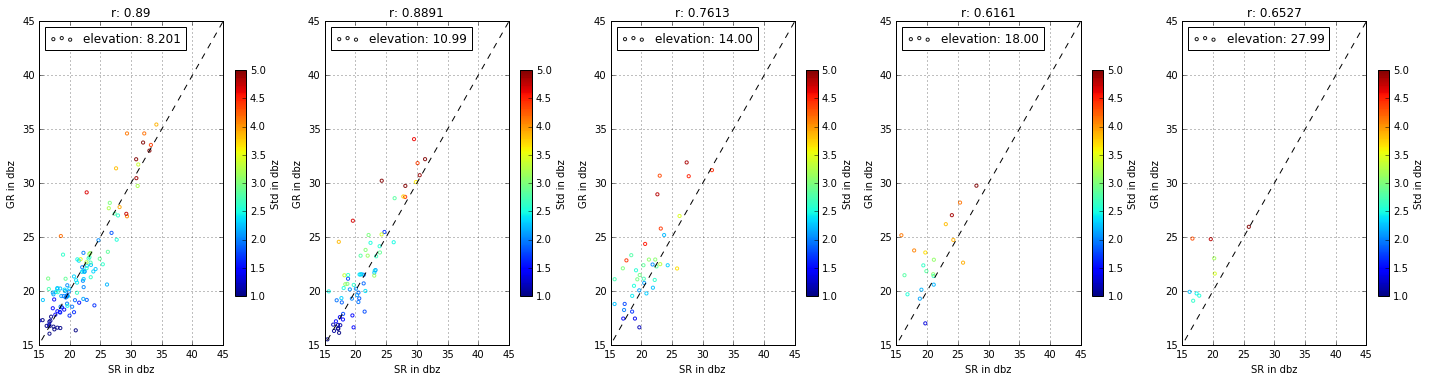

In [40]:
x1, x2 = 0, X
y1, y2 = 0, Y

dist = np.hypot(x2 - x1, y2 - y1)

dist = dist/10000.

aa=0.9
# Elevation unterteilen mit Cumulativer Summe
e_pos = gr_nr_elev.cumsum().astype(int)

pl.figure(figsize=(20,10))

for eee in range(len(gr_nr_elev)):
    pl.subplot(2,5,eee+1)
    
    if eee==0: 
        sc = pl.scatter(SR[0:e_pos[0]],
                   GR[0:e_pos[0]],
                   c=GRstd[0:e_pos[0]],
                   alpha=aa,label='elevation: '+str(gr_ele[0])[0:5],
                   color='black',
                   s=10,
                   vmin=1.,
                   vmax=5,
                   marker='o')
        sc.set_facecolor("none")
        pl.title('r: ' + corcor(SR[0:e_pos[0]],GR[0:e_pos[0]])[0:4])
        pl.legend(loc='upper left')
        cbar = pl.colorbar(shrink=0.7)
        cbar.ax.set_ylabel('Std in dbz', fontsize=10)
        
    else:
        sc = pl.scatter(SR[e_pos[eee-1]:e_pos[eee]],
                   GR[e_pos[eee-1]:e_pos[eee]],
                   c=GRstd[e_pos[eee-1]:e_pos[eee]],
                   vmin = 1.,
                   vmax = 5.,
                   alpha=aa,
                   label='elevation: ' + str(gr_ele[eee])[0:5],
                   color='black',
                   s=10,
                   marker='o')
        sc.set_facecolor("none")
        pl.title('r: ' + corcor(SR[e_pos[eee-1]:e_pos[eee]],GR[e_pos[eee-1]:e_pos[eee]])[0:6])
        pl.legend(loc='upper left')
        cbar = pl.colorbar(shrink=0.7)
        cbar.ax.set_ylabel('Std in dbz', fontsize=10)
        
    pl.xlabel('SR in dbz')
    pl.ylabel('GR in dbz')
    pl.grid()
    pl.xlim(15,45)
    pl.ylim(15,45)
    pl.plot([0,45],[0,45], color='black', ls='--')

pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/corr_elev_std.pdf')
pl.savefig('/automount/ftp/velibor/validation/corr_elev_std.png')
pl.show()

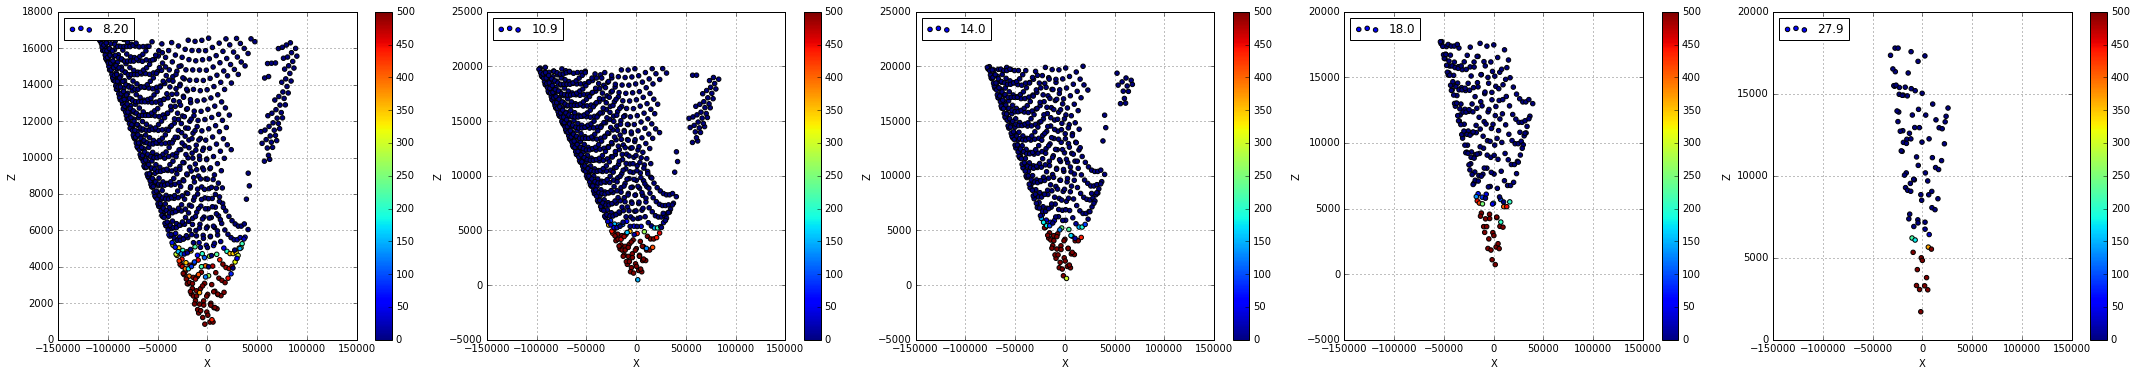

In [41]:
# Elevation unterteilen mit Cumulativer Summe
e_pos = gr_nr_elev.cumsum().astype(int)
from pcc import get_miub_cmap

pl.figure(figsize=(30,10))

for eee in range(len(gr_nr_elev)):
    pl.subplot(2,5,eee+1)
    
    if eee==0: 
        pl.scatter(X[0:e_pos[0]],Z[0:e_pos[0]],c=GRnum[0:e_pos[0]],label=str(gr_ele[0])[0:4],
                   cmap='jet', vmin=0, vmax=500)
        pl.legend(loc='upper left')
    else:
        pl.scatter(X[e_pos[eee-1]:e_pos[eee]],Z[e_pos[eee-1]:e_pos[eee]],c=GRnum[e_pos[eee-1]:e_pos[eee]],
                   label=str(gr_ele[eee])[0:4], cmap='jet', vmin=0, vmax=500)
        pl.legend(loc='upper left')
    pl.xlabel('X')
    pl.ylabel('Z')
    pl.grid()
    pl.xlim(-150000,150000)
    #pl.ylim(0,8000)
    pl.colorbar()


pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/GRnum.pdf')
pl.savefig('/automount/ftp/velibor/validation/GRnum.png')
pl.show()


In [42]:
"""time_now = time.strftime("%Y%m%d--%H%M%S")
match_run = 'match_' + time_now
savepfad = '/automount/ags/velibor/data/matching/'
os.mkdir(savepfad+match_run)

names = np.array(['X','Y','Z','SR','GR'])
np.save(savepfad + match_run+ '/match' + sr_data['date'][1].strftime("%Y%m%d--%H%M")+'.npy',
       [X,
       Y,
       Z,
       SR,
       GR,
       names])

!jupyter nbconvert --output-dir={savepfad+match_run} --to html pcc_gpm_matching_all_elevation.ipynb"""

'time_now = time.strftime("%Y%m%d--%H%M%S")\nmatch_run = \'match_\' + time_now\nsavepfad = \'/automount/ags/velibor/data/matching/\'\nos.mkdir(savepfad+match_run)\n\nnames = np.array([\'X\',\'Y\',\'Z\',\'SR\',\'GR\'])\nnp.save(savepfad + match_run+ \'/match\' + sr_data[\'date\'][1].strftime("%Y%m%d--%H%M")+\'.npy\',\n       [X,\n       Y,\n       Z,\n       SR,\n       GR,\n       names])\n\n!jupyter nbconvert --output-dir={savepfad+match_run} --to html pcc_gpm_matching_all_elevation.ipynb'

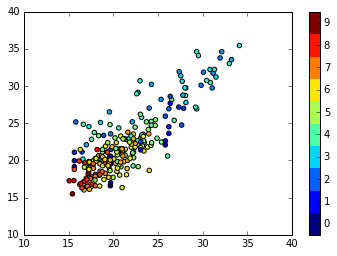

In [43]:
import matplotlib.colors

n = 10 # how many lines to draw or number of discrete color levels
cmap = pl.get_cmap("jet", n)

pl.scatter(SR,GR,c=Z)


norm= matplotlib.colors.BoundaryNorm(np.arange(0,n+1)-0.5, n)
sm = pl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
pl.colorbar(sm, ticks=np.arange(0,n))

pl.show()

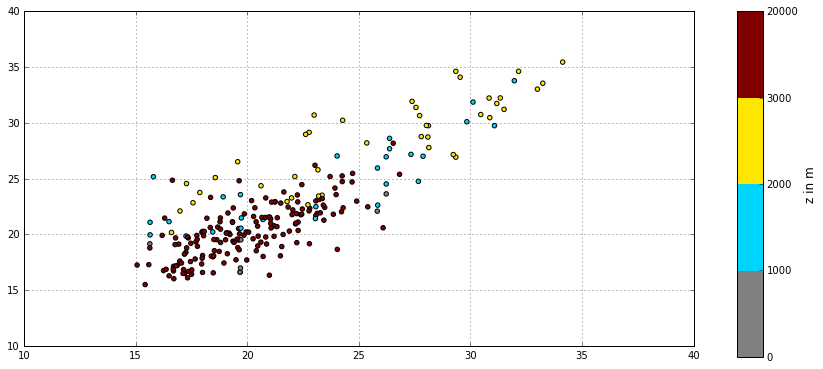

In [44]:
# setup the plot
fig, ax = pl.subplots(1,1, figsize=(12,6))

# define the data
x = SR
y = GR
tag = Z
#tag[10:12] = 0 # make sure there are some 0 values to showup as grey

# define the colormap
cmap = pl.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5,.5,.5,1.0)
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
#bounds = np.linspace(0,5000,10)
bounds = np.array([0,1000,2000,3000,20000])
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# make the scatter
scat = ax.scatter(x,y,c=tag,cmap=cmap, norm=norm)
# create a second axes for the colorbar
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, ticks=bounds, boundaries=bounds, format='%1i')

ax.set_title(' ')
ax2.set_ylabel('z in m', size=12)
ax.grid()
pl.show()

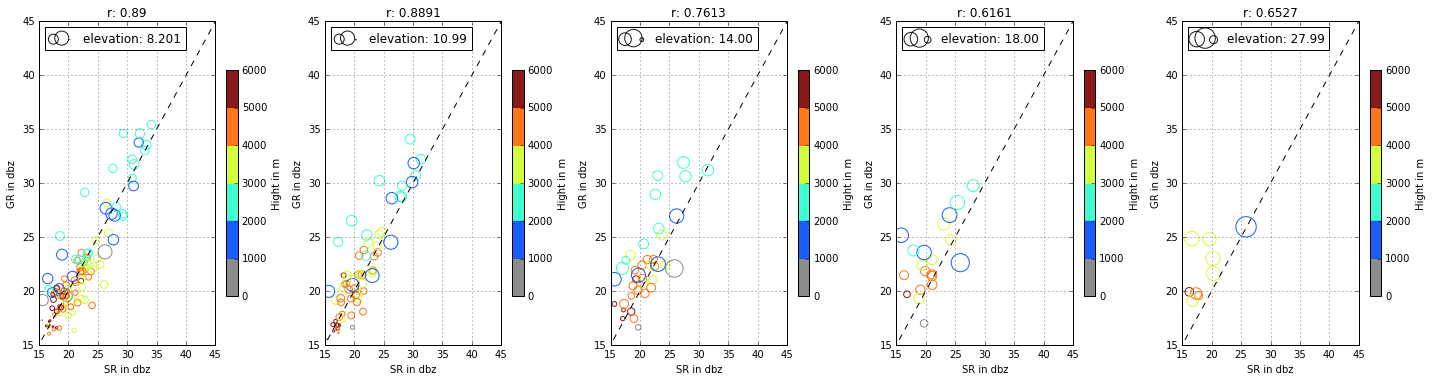

In [45]:
ZZ = Z.copy()
SRR = SR.copy()
GRR = GR.copy()
GN = GRnum.copy()

_num = 150
_h1, _h2 = 2000, 3000


# BB entfernen
"""ZZ[(Z>=_h1) & (Z<=_h2)] = np.nan
SRR[(Z>=_h1) & (Z<=_h2)] = np.nan
GRR[(Z>=_h1) & (Z<=_h2)] = np.nan
GN[(Z>=_h1) & (Z<=_h2)] = np.nan"""

# NUM entfernen
#ZZ[(GRnum < _num) ] = np.nan
#SRR[(GRnum < _num) ] = np.nan
#GRR[(GRnum < _num)] = np.nan
#GN[(GRnum < _num) ] = np.nan

cmap = pl.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5,.5,.5,1.0)
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
#bounds = np.linspace(0,5000,10)
bounds = np.arange(0,7000,1000)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

aa=0.9
# Elevation unterteilen mit Cumulativer Summe
e_pos = gr_nr_elev.cumsum().astype(int)

pl.figure(figsize=(20,10))

for eee in range(len(gr_nr_elev)):
    pl.subplot(2,5,eee+1)
    
    if eee==0: 
        sc = pl.scatter(SRR[0:e_pos[0]],
                   GRR[0:e_pos[0]],
                   c=ZZ[0:e_pos[0]],
                   alpha=aa,label='elevation: '+str(gr_ele[0])[0:5],
                   color='black',
                   s=GN[0:e_pos[0]]/10,
                   vmin=0.,
                   vmax=7000,
                   marker='o',
                   cmap=cmap, norm=norm)
        sc.set_facecolor("none")
        pl.title('r: ' + corcor(SRR[0:e_pos[0]],GRR[0:e_pos[0]])[0:4])
        pl.legend(loc='upper left')
        cbar = pl.colorbar(shrink=0.7, cmap=cmap, norm=norm, ticks=bounds, boundaries=bounds)
        cbar.ax.set_ylabel('Hight in m', fontsize=10)
        
    else:
        sc = pl.scatter(SRR[e_pos[eee-1]:e_pos[eee]],
                   GRR[e_pos[eee-1]:e_pos[eee]],
                   c=ZZ[e_pos[eee-1]:e_pos[eee]],
                   vmin = 0.,
                   vmax = 7000.,
                   alpha=aa,
                   label='elevation: ' + str(gr_ele[eee])[0:5],
                   color='black',
                   s=GN[e_pos[eee-1]:e_pos[eee]]/10,
                   marker='o', 
                   cmap=cmap, norm=norm)
        sc.set_facecolor("none")
        pl.title('r: ' + corcor(SRR[e_pos[eee-1]:e_pos[eee]],GRR[e_pos[eee-1]:e_pos[eee]])[0:6])
        pl.legend(loc='upper left')
        cbar = pl.colorbar(shrink=0.7, cmap=cmap, norm=norm, ticks=bounds, boundaries=bounds)
        cbar.ax.set_ylabel('Hight in m', fontsize=10)
        
    pl.xlabel('SR in dbz')
    pl.ylabel('GR in dbz')
    pl.grid()
    pl.xlim(15,45)
    pl.ylim(15,45)
    pl.plot([0,45],[0,45], color='black', ls='--')

pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/new_corr_elev_hight_num_withBB.pdf')
pl.savefig('/automount/ftp/velibor/validation/new_corr_elev_hight_num_withBB.png')
pl.show()

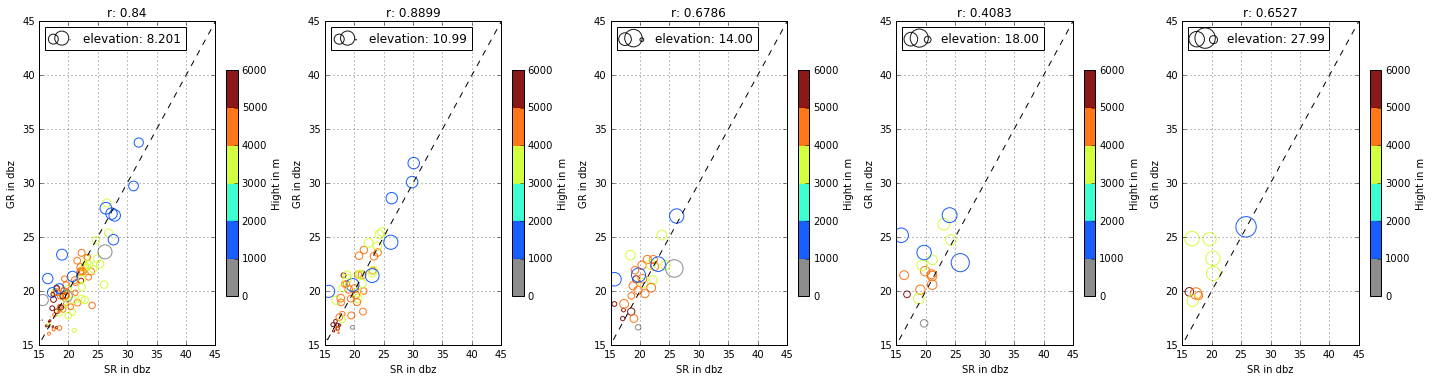

CPU times: user 3.6 s, sys: 3.15 s, total: 6.76 s
Wall time: 2.77 s


In [46]:
%%time
ZZ = Z.copy()
SRR = SR.copy()
GRR = GR.copy()
GN = GRnum.copy()

_num = 150
_h1, _h2 = 2000, 3000


# BB entfernen
ZZ[(Z>=_h1) & (Z<=_h2)] = np.nan
SRR[(Z>=_h1) & (Z<=_h2)] = np.nan
GRR[(Z>=_h1) & (Z<=_h2)] = np.nan
GN[(Z>=_h1) & (Z<=_h2)] = np.nan

# NUM entfernen
#ZZ[(GRnum < _num) ] = np.nan
#SRR[(GRnum < _num) ] = np.nan
#GRR[(GRnum < _num)] = np.nan
#GN[(GRnum < _num) ] = np.nan

cmap = pl.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5,.5,.5,1.0)
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
#bounds = np.linspace(0,5000,10)
bounds = np.arange(0,7000,1000)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

aa=0.9
# Elevation unterteilen mit Cumulativer Summe
e_pos = gr_nr_elev.cumsum().astype(int)

pl.figure(figsize=(20,10))

for eee in range(len(gr_nr_elev)):
    pl.subplot(2,5,eee+1)
    
    if eee==0: 
        sc = pl.scatter(SRR[0:e_pos[0]],
                   GRR[0:e_pos[0]],
                   c=ZZ[0:e_pos[0]],
                   alpha=aa,label='elevation: '+str(gr_ele[0])[0:5],
                   color='black',
                   s=GN[0:e_pos[0]]/10,
                   vmin=0.,
                   vmax=7000,
                   marker='o',
                   cmap=cmap, norm=norm)
        sc.set_facecolor("none")
        pl.title('r: ' + corcor(SRR[0:e_pos[0]],GRR[0:e_pos[0]])[0:4])
        pl.legend(loc='upper left')
        cbar = pl.colorbar(shrink=0.7, cmap=cmap, norm=norm, ticks=bounds, boundaries=bounds)
        cbar.ax.set_ylabel('Hight in m', fontsize=10)
        
    else:
        sc = pl.scatter(SRR[e_pos[eee-1]:e_pos[eee]],
                   GRR[e_pos[eee-1]:e_pos[eee]],
                   c=ZZ[e_pos[eee-1]:e_pos[eee]],
                   vmin = 0.,
                   vmax = 7000.,
                   alpha=aa,
                   label='elevation: ' + str(gr_ele[eee])[0:5],
                   color='black',
                   s=GN[e_pos[eee-1]:e_pos[eee]]/10,
                   marker='o', 
                   cmap=cmap, norm=norm)
        sc.set_facecolor("none")
        pl.title('r: ' + corcor(SRR[e_pos[eee-1]:e_pos[eee]],GRR[e_pos[eee-1]:e_pos[eee]])[0:6])
        pl.legend(loc='upper left')
        cbar = pl.colorbar(shrink=0.7, cmap=cmap, norm=norm, ticks=bounds, boundaries=bounds)
        cbar.ax.set_ylabel('Hight in m', fontsize=10)
        
    pl.xlabel('SR in dbz')
    pl.ylabel('GR in dbz')
    pl.grid()
    pl.xlim(15,45)
    pl.ylim(15,45)
    pl.plot([0,45],[0,45], color='black', ls='--')

pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/new_corr_elev_hight_num_withoutBB.pdf')
pl.savefig('/automount/ftp/velibor/validation/new_corr_elev_hight_num_withoutBB.png')
pl.show()

488.9991283416748
611.2489104270935
733.4986925125122
1711.4962190389633


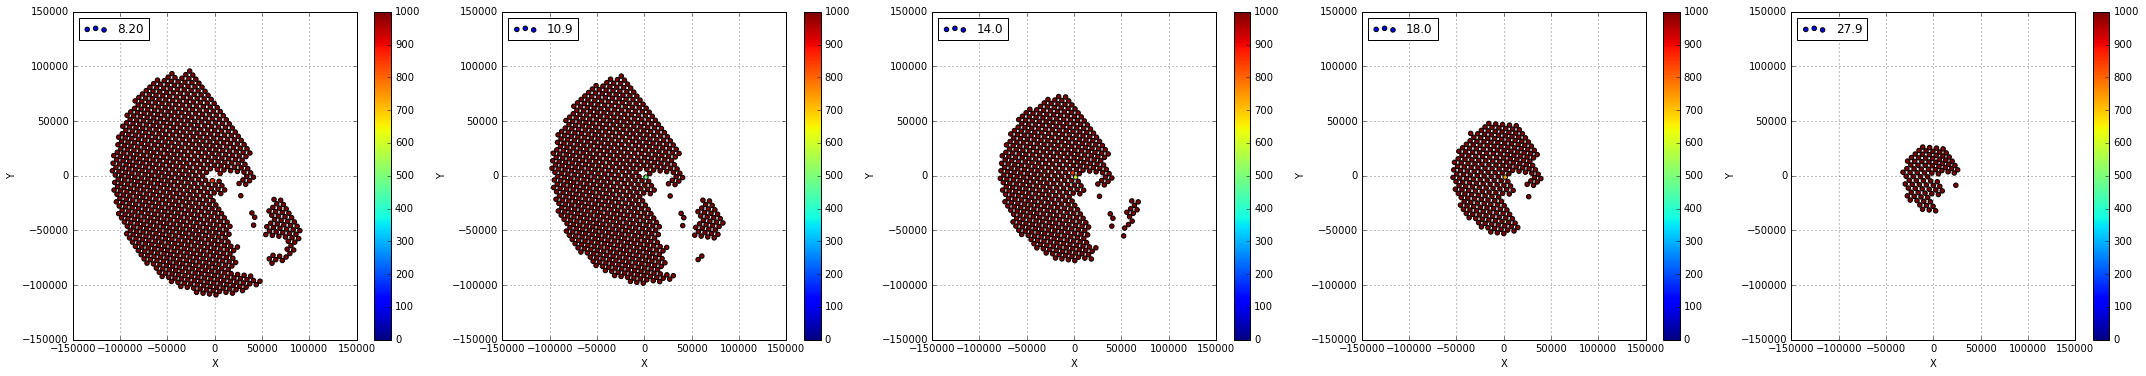

CPU times: user 4.74 s, sys: 3.85 s, total: 8.59 s
Wall time: 3.67 s


In [47]:
%%time
# Elevation unterteilen mit Cumulativer Summe
e_pos = gr_nr_elev.cumsum().astype(int)
from pcc import get_miub_cmap

pl.figure(figsize=(30,10))

for eee in range(len(gr_nr_elev)):
    pl.subplot(2,5,eee+1)
    
    if eee==0: 
        pl.scatter(X[0:e_pos[0]],Y[0:e_pos[0]],c=Z[0:e_pos[0]],label=str(gr_ele[0])[0:4],
                   cmap='jet', 
                   vmin=0,
                   vmax=1000)
        pl.legend(loc='upper left')
    else:
        pl.scatter(X[e_pos[eee-1]:e_pos[eee]],Y[e_pos[eee-1]:e_pos[eee]],c=Z[e_pos[eee-1]:e_pos[eee]],
                   label=str(gr_ele[eee])[0:4], cmap='jet',
                   vmin=0,
                   vmax=1000)
        print(np.nanmin(Z[e_pos[eee-1]:e_pos[eee]]))
        pl.legend(loc='upper left')
    pl.xlabel('X')
    pl.ylabel('Y')
    pl.grid()
    pl.xlim(-150000,150000)
    pl.ylim(-150000,150000)
    #pl.ylim(0,8000)
    pl.colorbar()


pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/SR_hights.pdf')
pl.savefig('/automount/ftp/velibor/validation/SR_hights.png')

pl.show()

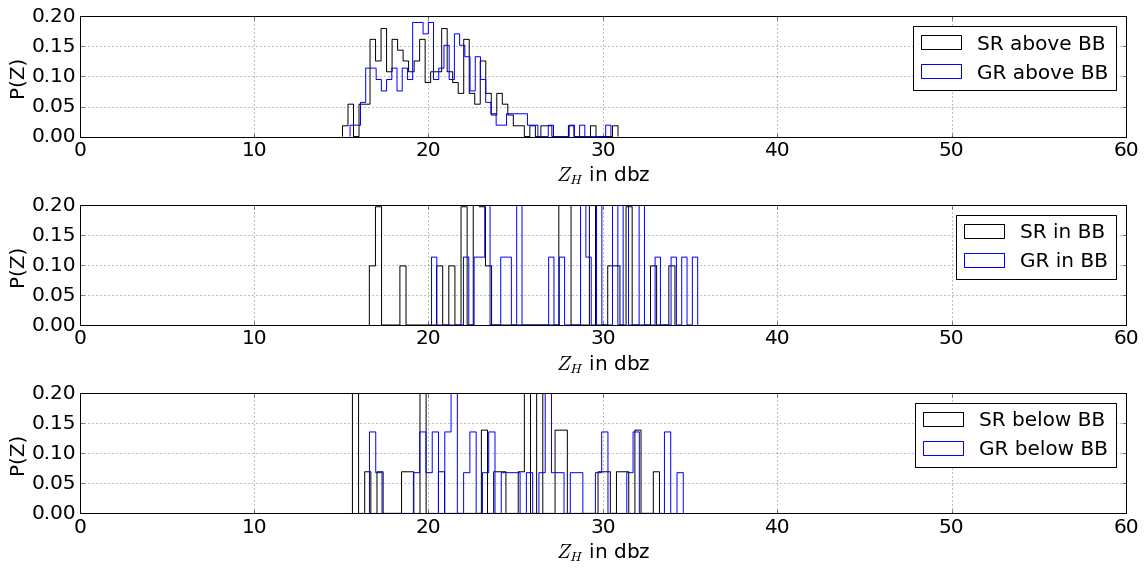

In [48]:
Zh = Z.copy()
SRh = SR.copy()
GRh = GR.copy()
Gh = GRnum.copy()

SR_top = SRh[Zh>2800]
SR_bb = SRh[(Zh<2800) & (Zh>2200)]
SR_bot = SRh[Zh<2200]

GR_top = GRh[Zh>2800]
GR_bb = GRh[(Zh<2800) & (Zh>2200)]
GR_bot = GRh[Zh<2200]

mm_top = ~np.isnan(GR_top) & ~np.isnan(SR_top)
mm_bb = ~np.isnan(GR_bb) & ~np.isnan(SR_bb)
mm_bot = ~np.isnan(GR_bot) & ~np.isnan(SR_bot)


pl.figure(figsize=(16,8))
pl.subplot(3,1,1)
pl.hist(SR_top[mm_top],bins=50, facecolor="None", alpha=1, edgecolor='black', histtype='step', label='SR above BB', normed=1,ls='-')
pl.hist(GR_top[mm_top],bins=50, facecolor="None", alpha=1, edgecolor='blue', histtype='step', label='GR above BB', normed=1,ls='-')
pl.grid()
pl.legend(fontsize=20)
#pl.ylim(top=90)
pl.ylabel('P(Z)', fontsize=20)
pl.xlabel(r'$Z_H$ in dbz', fontsize=20)
pl.xticks(fontsize=20); pl.yticks(fontsize=20)
pl.xlim(0,60); pl.ylim(0,0.2)

pl.subplot(3,1,2)
pl.hist(SR_bb[mm_bb],bins=50, facecolor="None", alpha=1, edgecolor='black', histtype='step', label='SR in BB', normed=1,ls='-')
pl.hist(GR_bb[mm_bb],bins=50, facecolor="None", alpha=1, edgecolor='blue', histtype='step', label='GR in BB', normed=1,ls='-')
pl.grid()
pl.legend(fontsize=20)
#pl.ylim(top=90)
pl.ylabel('P(Z)', fontsize=20)
pl.xlabel(r'$Z_H$ in dbz', fontsize=20)
pl.xticks(fontsize=20); pl.yticks(fontsize=20)
pl.xlim(0,60); pl.ylim(0,0.2)

pl.subplot(3,1,3)
pl.hist(SR_bot[mm_bot],bins=50, facecolor="None", alpha=1, edgecolor='black', histtype='step', label='SR below BB', normed=1,ls='-')
pl.hist(GR_bot[mm_bot],bins=50, facecolor="None", alpha=1, edgecolor='blue', histtype='step', label='GR below BB', normed=1,ls='-')
pl.grid()
pl.legend(fontsize=20)
#pl.ylim(top=90)
pl.ylabel('P(Z)', fontsize=20)
pl.xlabel(r'$Z_H$ in dbz', fontsize=20)
pl.xticks(fontsize=20); pl.yticks(fontsize=20)
pl.xlim(0,60); pl.ylim(0,0.2)


pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/matching_hist.pdf')
pl.savefig('/automount/ftp/velibor/validation/matching_hist.png')
pl.show()

In [49]:


len(GR_bot[mm_bot])

41

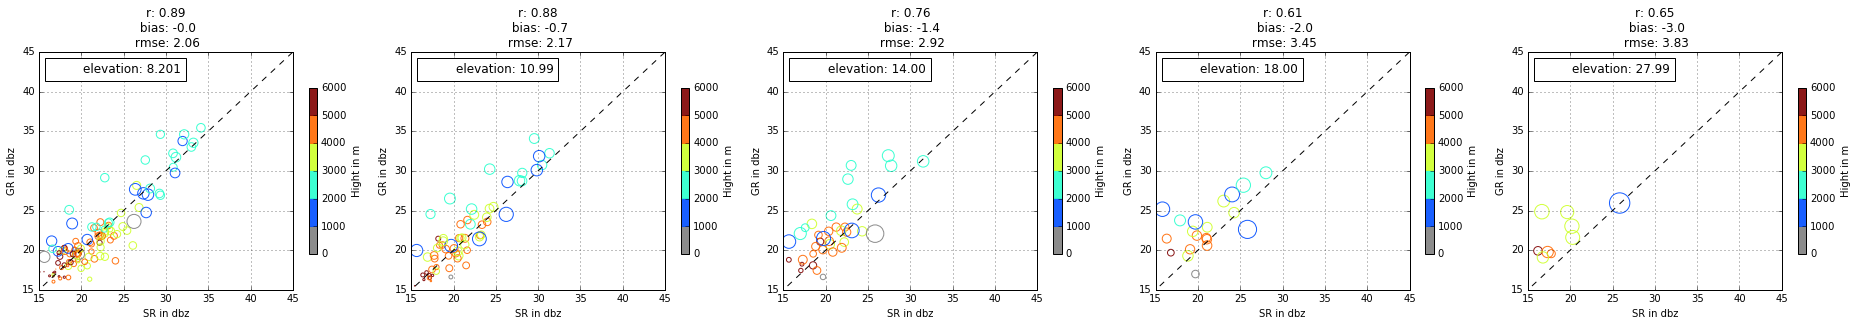

In [50]:
def stats(a, b):
    """beschriften und Dict!"""
    mask = ~np.isnan(a) & ~np.isnan(b)
    H = len(a[mask])
    bias = np.nansum(a - b)/H
    rmse = np.sqrt(np.nansum(((a -b )**2.0)/H))
    
    return bias, rmse
    
    
    

ZZ = Z.copy()
SRR = SR.copy()
GRR = GR.copy()
GN = GRnum.copy()

_num = 150
_h1, _h2 = 2200, 2800


# BB entfernen
"""ZZ[(Z>=_h1) & (Z<=_h2)] = np.nan
SRR[(Z>=_h1) & (Z<=_h2)] = np.nan
GRR[(Z>=_h1) & (Z<=_h2)] = np.nan
GN[(Z>=_h1) & (Z<=_h2)] = np.nan"""

# NUM entfernen
#ZZ[(GRnum < _num) ] = np.nan
#SRR[(GRnum < _num) ] = np.nan
#GRR[(GRnum < _num)] = np.nan
#GN[(GRnum < _num) ] = np.nan

cmap = pl.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5,.5,.5,1.0)
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
#bounds = np.linspace(0,5000,10)
bounds = np.arange(0,7000,1000)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

aa=0.9
# Elevation unterteilen mit Cumulativer Summe
e_pos = gr_nr_elev.cumsum().astype(int)

pl.figure(figsize=(26,8))

for eee in range(len(gr_nr_elev)):
    pl.subplot(2,5,eee+1)
    
    if eee==0: 
        sc = pl.scatter(SRR[0:e_pos[0]],
                   GRR[0:e_pos[0]],
                   c=ZZ[0:e_pos[0]],
                   alpha=aa,label='elevation: '+str(gr_ele[0])[0:5],
                   color='black',
                   s=GN[0:e_pos[0]]/10,
                   vmin=0.,
                   vmax=7000,
                   marker='o',
                   cmap=cmap, norm=norm)
        sc.set_facecolor("none")
        pl.title('r: ' + corcor(SRR[0:e_pos[0]],GRR[0:e_pos[0]])[0:4]+
                '\n bias: ' +  str(stats(SRR[0:e_pos[0]],GRR[0:e_pos[0]])[0])[0:4]+
                 '\n rmse: ' + str(stats(SRR[0:e_pos[0]],GRR[0:e_pos[0]])[1])[0:4]
                )
        pl.legend(loc='upper left',markerscale=0)
        cbar = pl.colorbar(shrink=0.7, cmap=cmap, norm=norm, ticks=bounds, boundaries=bounds)
        cbar.ax.set_ylabel('Hight in m', fontsize=10)
        
    else:
        sc = pl.scatter(SRR[e_pos[eee-1]:e_pos[eee]],
                   GRR[e_pos[eee-1]:e_pos[eee]],
                   c=ZZ[e_pos[eee-1]:e_pos[eee]],
                   vmin = 0.,
                   vmax = 7000.,
                   alpha=aa,
                   label='elevation: ' + str(gr_ele[eee])[0:5],
                   color='black',
                   s=GN[e_pos[eee-1]:e_pos[eee]]/10,
                   marker='o', 
                   cmap=cmap, norm=norm)
        sc.set_facecolor("none")
        pl.title('r: ' + corcor(SRR[e_pos[eee-1]:e_pos[eee]],GRR[e_pos[eee-1]:e_pos[eee]])[0:4]+
                '\n bias: ' +  str(stats(SRR[e_pos[eee-1]:e_pos[eee]],GRR[e_pos[eee-1]:e_pos[eee]])[0])[0:4] +
                 '\n rmse: ' + str(stats(SRR[e_pos[eee-1]:e_pos[eee]],GRR[e_pos[eee-1]:e_pos[eee]])[1])[0:4]
                )
        pl.legend(loc='upper left',markerscale=0)
        cbar = pl.colorbar(shrink=0.7, cmap=cmap, norm=norm, ticks=bounds, boundaries=bounds)
        cbar.ax.set_ylabel('Hight in m', fontsize=10)
        
    pl.xlabel('SR in dbz')
    pl.ylabel('GR in dbz')
    pl.grid()
    pl.xlim(15,45)
    pl.ylim(15,45)
    pl.plot([0,45],[0,45], color='black', ls='--')

pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/new_corr_elev_hight_num_BB_stats.pdf')
pl.savefig('/automount/ftp/velibor/validation/new_corr_elev_hight_num_BB_stats.png')
pl.show()

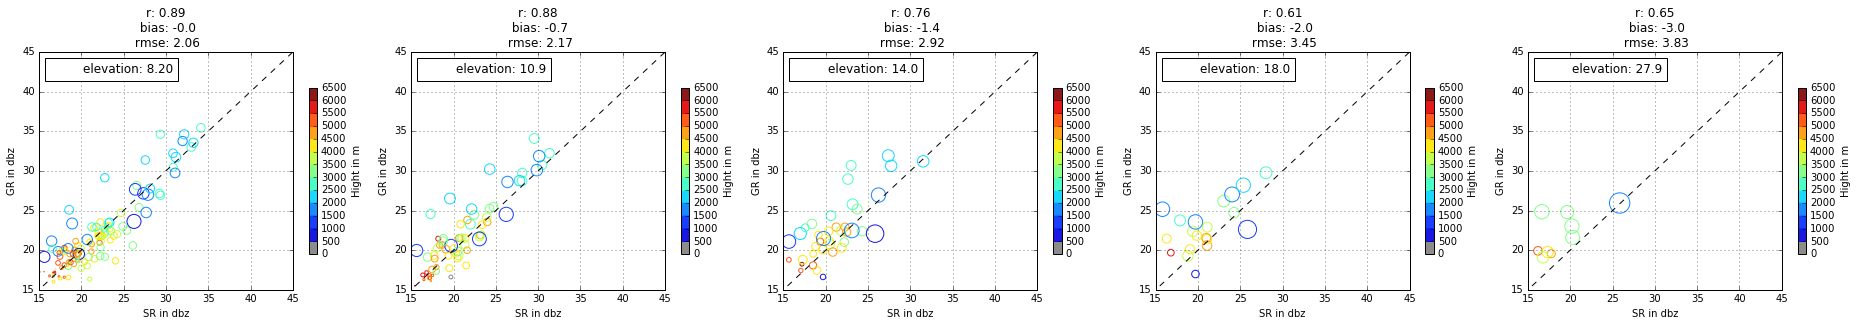

In [51]:
def stats(a, b):
    """beschriften und Dict!"""
    mask = ~np.isnan(a) & ~np.isnan(b)
    H = len(a[mask])
    bias = np.nansum(a - b)/H
    rmse = np.sqrt(np.nansum(((a -b )**2.0)/H))
    
    return bias, rmse
    
    
    

ZZ = Z.copy()
SRR = SR.copy()
GRR = GR.copy()
GN = GRnum.copy()

_num = 150
_h1, _h2 = 2200, 2800


# BB entfernen
"""ZZ[(Z>=_h1) & (Z<=_h2)] = np.nan
SRR[(Z>=_h1) & (Z<=_h2)] = np.nan
GRR[(Z>=_h1) & (Z<=_h2)] = np.nan
GN[(Z>=_h1) & (Z<=_h2)] = np.nan"""

# NUM entfernen
#ZZ[(GRnum < _num) ] = np.nan
#SRR[(GRnum < _num) ] = np.nan
#GRR[(GRnum < _num)] = np.nan
#GN[(GRnum < _num) ] = np.nan

cmap = pl.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5,.5,.5,1.0)
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
#bounds = np.linspace(0,5000,10)
bounds = np.arange(0,7000,500)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

aa=0.9
# Elevation unterteilen mit Cumulativer Summe
e_pos = gr_nr_elev.cumsum().astype(int)

pl.figure(figsize=(26,8))

for eee in range(len(gr_nr_elev)):
    pl.subplot(2,5,eee+1)
    
    if eee==0: 
        sc = pl.scatter(SRR[0:e_pos[0]],
                   GRR[0:e_pos[0]],
                   c=ZZ[0:e_pos[0]],
                   alpha=aa,label='elevation: '+str(gr_ele[0])[0:4],
                   color='black',
                   s=GN[0:e_pos[0]]/10,
                   vmin=0.,
                   vmax=7000,
                   marker='o',
                   cmap=cmap, norm=norm)
        sc.set_facecolor("none")
        pl.title('r: ' + corcor(SRR[0:e_pos[0]],GRR[0:e_pos[0]])[0:4]+
                '\n bias: ' +  str(stats(SRR[0:e_pos[0]],GRR[0:e_pos[0]])[0])[0:4]+
                 '\n rmse: ' + str(stats(SRR[0:e_pos[0]],GRR[0:e_pos[0]])[1])[0:4]
                )
        pl.legend(loc='upper left',markerscale=0)
        cbar = pl.colorbar(shrink=0.7, cmap=cmap, norm=norm, ticks=bounds, boundaries=bounds)
        cbar.ax.set_ylabel('Hight in m', fontsize=10)
        
    else:
        sc = pl.scatter(SRR[e_pos[eee-1]:e_pos[eee]],
                   GRR[e_pos[eee-1]:e_pos[eee]],
                   c=ZZ[e_pos[eee-1]:e_pos[eee]],
                   vmin = 0.,
                   vmax = 7000.,
                   alpha=aa,
                   label='elevation: ' + str(gr_ele[eee])[0:4],
                   color='black',
                   s=GN[e_pos[eee-1]:e_pos[eee]]/10,
                   marker='o', 
                   cmap=cmap, norm=norm)
        sc.set_facecolor("none")
        pl.title('r: ' + corcor(SRR[e_pos[eee-1]:e_pos[eee]],GRR[e_pos[eee-1]:e_pos[eee]])[0:4]+
                '\n bias: ' +  str(stats(SRR[e_pos[eee-1]:e_pos[eee]],GRR[e_pos[eee-1]:e_pos[eee]])[0])[0:4] +
                 '\n rmse: ' + str(stats(SRR[e_pos[eee-1]:e_pos[eee]],GRR[e_pos[eee-1]:e_pos[eee]])[1])[0:4]
                )
        pl.legend(loc='upper left',markerscale=0)
        cbar = pl.colorbar(shrink=0.7, cmap=cmap, norm=norm, ticks=bounds, boundaries=bounds)
        cbar.ax.set_ylabel('Hight in m', fontsize=10)
        
    pl.xlabel('SR in dbz')
    pl.ylabel('GR in dbz')
    pl.grid()
    pl.xlim(15,45)
    pl.ylim(15,45)
    pl.plot([0,45],[0,45], color='black', ls='--')

pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/new_corr_elev_hight_num_BB_stats2.pdf')
pl.savefig('/automount/ftp/velibor/validation/new_corr_elev_hight_num_BB_stats2.png')
pl.show()

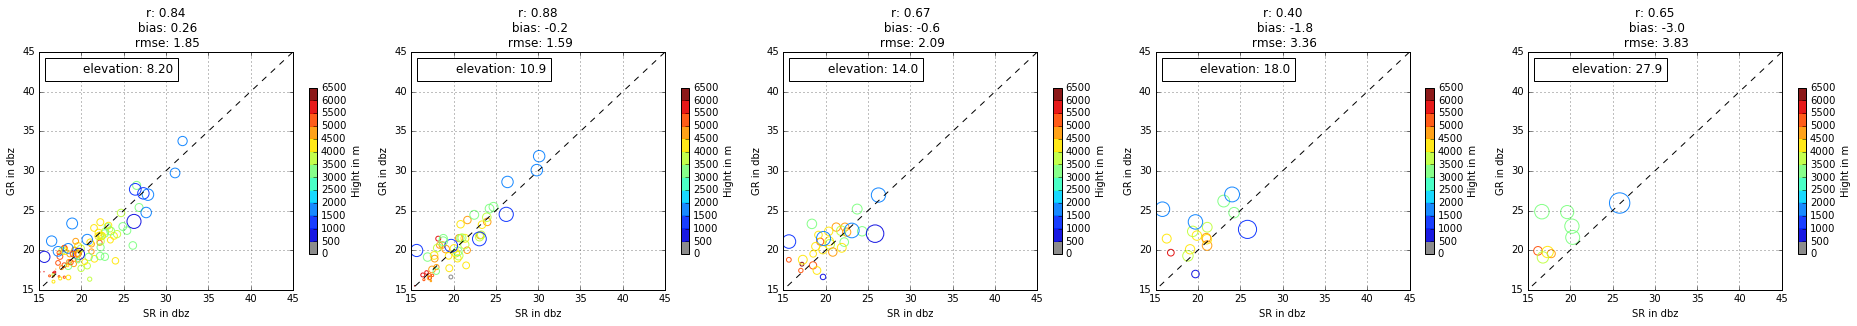

In [52]:
def stats(a, b):
    """beschriften und Dict!"""
    mask = ~np.isnan(a) & ~np.isnan(b)
    H = len(a[mask])
    bias = np.nansum(a - b)/H
    rmse = np.sqrt(np.nansum(((a -b )**2.0)/H))
    
    return bias, rmse
    
    
    

ZZ = Z.copy()
SRR = SR.copy()
GRR = GR.copy()
GN = GRnum.copy()

_num = 150
_h1, _h2 = 2000, 3000


# BB entfernen
ZZ[(Z>=_h1) & (Z<=_h2)] = np.nan
SRR[(Z>=_h1) & (Z<=_h2)] = np.nan
GRR[(Z>=_h1) & (Z<=_h2)] = np.nan
GN[(Z>=_h1) & (Z<=_h2)] = np.nan

# NUM entfernen
#ZZ[(GRnum < _num) ] = np.nan
#SRR[(GRnum < _num) ] = np.nan
#GRR[(GRnum < _num)] = np.nan
#GN[(GRnum < _num) ] = np.nan

cmap = pl.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5,.5,.5,1.0)
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
#bounds = np.linspace(0,5000,10)
bounds = np.arange(0,7000,500)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

aa=0.9
# Elevation unterteilen mit Cumulativer Summe
e_pos = gr_nr_elev.cumsum().astype(int)

pl.figure(figsize=(26,8))

for eee in range(len(gr_nr_elev)):
    pl.subplot(2,5,eee+1)
    
    if eee==0: 
        sc = pl.scatter(SRR[0:e_pos[0]],
                   GRR[0:e_pos[0]],
                   c=ZZ[0:e_pos[0]],
                   alpha=aa,label='elevation: '+str(gr_ele[0])[0:4],
                   color='black',
                   s=GN[0:e_pos[0]]/10,
                   vmin=0.,
                   vmax=7000,
                   marker='o',
                   cmap=cmap, norm=norm)
        sc.set_facecolor("none")
        pl.title('r: ' + corcor(SRR[0:e_pos[0]],GRR[0:e_pos[0]])[0:4]+
                '\n bias: ' +  str(stats(SRR[0:e_pos[0]],GRR[0:e_pos[0]])[0])[0:4]+
                 '\n rmse: ' + str(stats(SRR[0:e_pos[0]],GRR[0:e_pos[0]])[1])[0:4]
                )
        pl.legend(loc='upper left',markerscale=0)
        cbar = pl.colorbar(shrink=0.7, cmap=cmap, norm=norm, ticks=bounds, boundaries=bounds)
        cbar.ax.set_ylabel('Hight in m', fontsize=10)
        
    else:
        sc = pl.scatter(SRR[e_pos[eee-1]:e_pos[eee]],
                   GRR[e_pos[eee-1]:e_pos[eee]],
                   c=ZZ[e_pos[eee-1]:e_pos[eee]],
                   vmin = 0.,
                   vmax = 7000.,
                   alpha=aa,
                   label='elevation: ' + str(gr_ele[eee])[0:4],
                   color='black',
                   s=GN[e_pos[eee-1]:e_pos[eee]]/10,
                   marker='o', 
                   cmap=cmap, norm=norm)
        sc.set_facecolor("none")
        pl.title('r: ' + corcor(SRR[e_pos[eee-1]:e_pos[eee]],GRR[e_pos[eee-1]:e_pos[eee]])[0:4]+
                '\n bias: ' +  str(stats(SRR[e_pos[eee-1]:e_pos[eee]],GRR[e_pos[eee-1]:e_pos[eee]])[0])[0:4] +
                 '\n rmse: ' + str(stats(SRR[e_pos[eee-1]:e_pos[eee]],GRR[e_pos[eee-1]:e_pos[eee]])[1])[0:4]
                )
        pl.legend(loc='upper left',markerscale=0)
        cbar = pl.colorbar(shrink=0.7, cmap=cmap, norm=norm, ticks=bounds, boundaries=bounds)
        cbar.ax.set_ylabel('Hight in m', fontsize=10)
        
    pl.xlabel('SR in dbz')
    pl.ylabel('GR in dbz')
    pl.grid()
    pl.xlim(15,45)
    pl.ylim(15,45)
    pl.plot([0,45],[0,45], color='black', ls='--')

pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/new_corr_elev_hight_num_BB_stats2_withoutBB.pdf')
pl.savefig('/automount/ftp/velibor/validation/new_corr_elev_hight_num_BB_stats2_withoutBB.png')
pl.show()

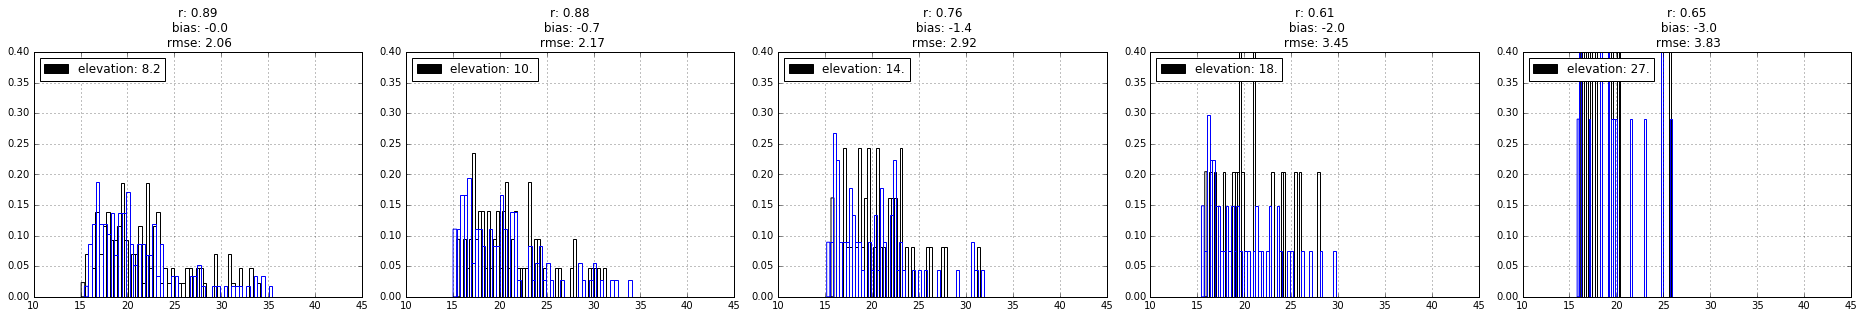

In [53]:
def stats(a, b):
    """beschriften und Dict!"""
    mask = ~np.isnan(a) & ~np.isnan(b)
    H = len(a[mask])
    bias = np.nansum(a - b)/H
    rmse = np.sqrt(np.nansum(((a -b )**2.0)/H))
    
    return bias, rmse
    
    
    

ZZ = Z.copy()
SRR = SR.copy()
GRR = GR.copy()
GN = GRnum.copy()

_num = 150
_h1, _h2 = 2200, 2800


# BB entfernen
"""ZZ[(Z>=_h1) & (Z<=_h2)] = np.nan
SRR[(Z>=_h1) & (Z<=_h2)] = np.nan
GRR[(Z>=_h1) & (Z<=_h2)] = np.nan
GN[(Z>=_h1) & (Z<=_h2)] = np.nan"""

# NUM entfernen
#ZZ[(GRnum < _num) ] = np.nan
#SRR[(GRnum < _num) ] = np.nan
#GRR[(GRnum < _num)] = np.nan
#GN[(GRnum < _num) ] = np.nan

cmap = pl.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5,.5,.5,1.0)
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
#bounds = np.linspace(0,5000,10)
bounds = np.arange(0,7000,500)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

aa=0.9
# Elevation unterteilen mit Cumulativer Summe
e_pos = gr_nr_elev.cumsum().astype(int)

pl.figure(figsize=(26,8))

for eee in range(len(gr_nr_elev)):
    pl.subplot(2,5,eee+1)
    
    if eee==0: 
        mask1 = ~np.isnan(SRR[0:e_pos[0]])
        mask2 = ~np.isnan(GRR[0:e_pos[0]])
                             
        pl.hist(SRR[0:e_pos[0]][mask1],bins=50,
                   label='elevation: '+str(gr_ele[0])[0:3],
                   color='black', normed=1, facecolor="None", alpha=1, edgecolor='black')
        pl.hist(GRR[0:e_pos[0]][mask2],bins=50,
                   color='blue', normed=1, facecolor="None", alpha=1, edgecolor='blue')

        pl.title('r: ' + corcor(SRR[0:e_pos[0]],GRR[0:e_pos[0]])[0:4]+
                '\n bias: ' +  str(stats(SRR[0:e_pos[0]],GRR[0:e_pos[0]])[0])[0:4]+
                 '\n rmse: ' + str(stats(SRR[0:e_pos[0]],GRR[0:e_pos[0]])[1])[0:4]
                )
        pl.legend(loc='upper left')

        
    else:
        mask3 = ~np.isnan(SRR[e_pos[eee-1]:e_pos[eee]])
        mask4 = ~np.isnan(GRR[e_pos[eee-1]:e_pos[eee]])
        
        pl.hist(SRR[e_pos[eee-1]:e_pos[eee]][mask3],bins=50,
                   label='elevation: '+str(gr_ele[eee])[0:3],
                   color='black', normed=1, facecolor="None", alpha=1, edgecolor='black')
        pl.hist(GRR[e_pos[eee-1]:e_pos[eee]][mask4],bins=50,
                   color='blue', normed=1, facecolor="None", alpha=1, edgecolor='blue')
    
        pl.title('r: ' + corcor(SRR[e_pos[eee-1]:e_pos[eee]],GRR[e_pos[eee-1]:e_pos[eee]])[0:4]+
                '\n bias: ' +  str(stats(SRR[e_pos[eee-1]:e_pos[eee]],GRR[e_pos[eee-1]:e_pos[eee]])[0])[0:4] +
                 '\n rmse: ' + str(stats(SRR[e_pos[eee-1]:e_pos[eee]],GRR[e_pos[eee-1]:e_pos[eee]])[1])[0:4]
                )
        pl.legend(loc='upper left',markerscale=0)

        
    #pl.xlabel('SR in dbz')
    #pl.ylabel('GR in dbz')
    pl.grid()
    pl.xlim(10,45)
    pl.ylim(0,0.4)
    #pl.plot([0,45],[0,45], color='black', ls='--')

pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/new_corr_elev_hight_num_BB_stats2_hist.pdf')
pl.savefig('/automount/ftp/velibor/validation/new_corr_elev_hight_num_BB_stats2_hist.png')
pl.show()

('Ka: ', 25)
('Ku: ', 49)
('Ku - Ka (DFR): ', 24)


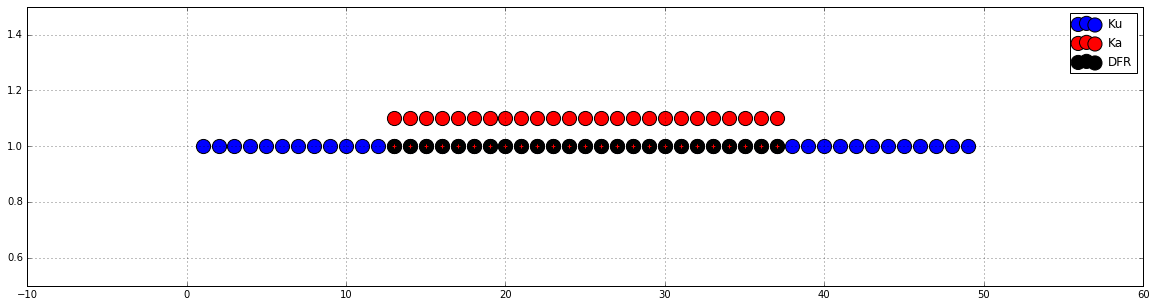

In [54]:
def show_swath():
    """
    Simple Darstellung des DPR Swaths
    
    w.i.p MS fehlt
    """
    import matplotlib.pyplot as pl
    import numpy as np
    swath_ku = np.arange(1,50,1) 
    pos_ku =  np.ones(swath_ku.shape)

    swath_ka = np.arange(1+12,26+12,1) 
    pos_ka =  np.ones(swath_ka.shape)+0.1

    print('Ka: ',len(swath_ka))
    print('Ku: ',len(swath_ku))
    print('Ku - Ka (DFR): ',len(swath_ku)-len(swath_ka))

    pl.figure(figsize=(20,5))
    pl.scatter(swath_ku,pos_ku, c='blue', s=200, label='Ku')
    pl.scatter(swath_ka,pos_ka, c='red', s=200, label='Ka')

    pl.scatter(swath_ku[12:26+11],pos_ku[12:26+11], c='black', s=200, label='DFR')
    pl.scatter(swath_ku[12:26+11],pos_ku[12:26+11], c='red', s=20, marker='+')

    pl.grid()
    pl.legend()
    pl.ylim(0.5,1.5)
    pl.show()

show_swath()